In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import joblib

## Downloading locally
- The easiest way to install diad fit is by removing the #, and running this once per computer. When I update the code, you'll need to get the new tag off GitHub:
https://github.com/PennyWieser/DiadFit/tags
Right click on the top one, over the 'zip' icon, click copy link address
- If youve already done this for Ne, you dont need to do here too

In [2]:
#!pip install --upgrade "https://github.com/PennyWieser/DiadFit/archive/refs/tags/0.0.11.zip"

### This imports DiadFit, and gives you the version. In all communication with Penny, make sure you say the version!


In [3]:
import DiadFit as pf
pf.__version__

'0.0.29'

In [4]:
DayFolder=r'G:\My Drive\Berkeley_NEW\DiadFit_outer\docs\Examples\Diad_Fitting_Nov22nd2022'
meta_path=DayFolder +  '\MetaData'
spectra_path=DayFolder + '\Spectra'

In [5]:
# This specifies what file type your Raman exported in. 
filetype='headless_txt' # Specifies raman file format 
file_ext='.txt'
prefix=False

## Now load the files of interest

In [6]:
Diad_Files_Weak = joblib.load('Diad_Files_Grp1.sav')

In [7]:
Diad_Files_Weak

['POC8.txt',
 'POC1.txt',
 'POC7.txt',
 'POC6.txt',
 'POC5.txt',
 'POC4.txt',
 'POC2.txt',
 'POC3.txt']

In [8]:
# Select one file to tweak fit on
filename_Weak=Diad_Files_Weak[5]
filename_Weak

'POC4.txt'

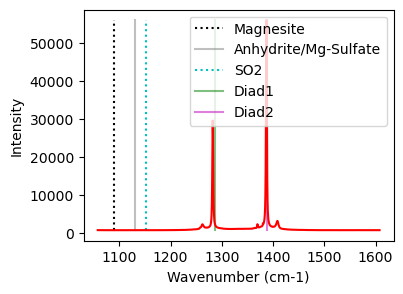

In [9]:
plot1=pf.plot_diad(path=spectra_path, filename=filename_Weak, filetype=filetype)

## Decide if you want a secondary peak
- If you dont have the peak, it is only a little slower, but it works if it only appears in a small number of spectra still

In [10]:
# Decide if you want to fit a carbonate peak or not here. 
fit_sec_peak=False

if fit_sec_peak is True:

    # Tweak options here, can exclude a range for example using exclude_range=Tuple[float, float]
    generic_Config=pf.generic_peak_config(lower_bck=(1110, 1130), 
    upper_bck=(1160, 1180), cent_generic=1150, name='SO2')

    generic_fit=pf.fit_generic_peak(config=generic_Config, path=spectra_path, 
    filename=filename_Weak, filetype=filetype)
    generic_fit

## Now lets inspect the diads and get their approximate positions
- As with generic peak, you can exclude 2 segments (e.g. around cosmic rays)
- You then specify how many peaks you want to fit on each diad. 1 means just the strong peak, 2 hotbands, and 3 for Diad2 would also fit the C13 peak if present. 
- The identify_diad_peaks then uses scipy findpeaks to identify the positions of the 2 diads, and any other peaks the user asks for. These are saved, and fed into the later functions for peak fitting. 

In [11]:
diad_id_config=pf.diad_id_config(height=100,  distance=10, prominence=400)
diad_id_config

diad_id_config(exclude_range1=None, exclude_range2=None, approx_diad2_pos=(1379, 1395), approx_diad1_pos=(1275, 1295), height=100, distance=10, threshold=0.5, width=0.5, prominence=400, plot_figure=True)

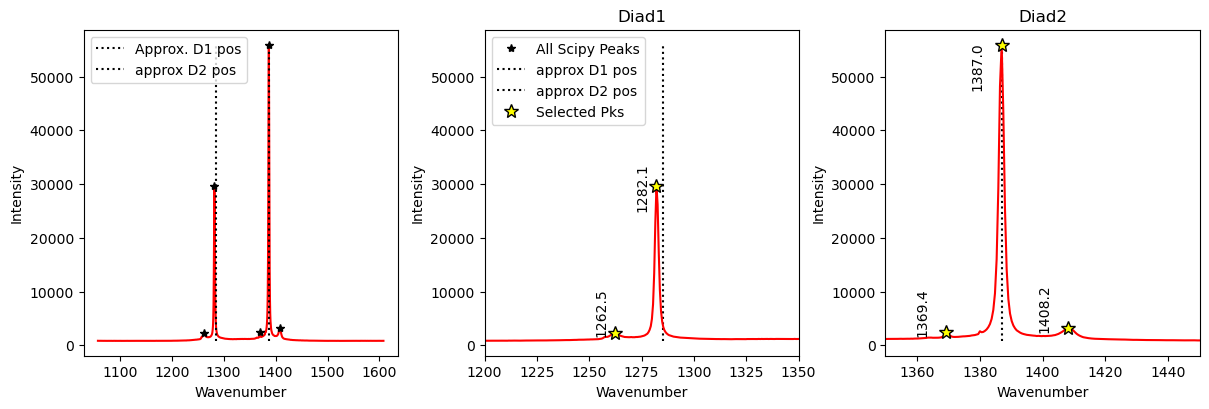

In [12]:
# Specify the number of peaks, 1 = just peak, 2 = Peak+hot bands
n_peaks_diad1=2
n_peaks_diad2=3
    
diad1_peaks, diad2_peaks=pf.identify_diad_peaks(
    config=diad_id_config, path=spectra_path, filename=filename_Weak,
filetype=filetype, n_peaks_diad1=n_peaks_diad1, n_peaks_diad2=n_peaks_diad2)

In [13]:
diad2_peaks

(1386.990031, 1408.239942, 1369.390939)

In [14]:
## Choose a model - option, pseudovoigt or voigt
model_name='PseudoVoigtModel'

## Fit Diad 1
- You can tweak the parameters in diad1_fit_config

In [15]:
diad1_fit_config_init=pf.diad1_fit_config(
    peak_pos_gauss=1287,
    gauss_sigma=20,
    model_name=model_name,
N_poly_bck_diad1=3, lower_bck_diad1=(1180, 1220),
upper_bck_diad1=(1330, 1350),
diad_sigma=1, sigma_allowance=2,

x_range_residual=10, x_range_baseline=30, 
 y_range_baseline=1000, 
    HB_amplitude=500, diad_amplitude=10000)
diad1_fit_config_init

diad1_fit_config(model_name='PseudoVoigtModel', peak_pos_gauss=1287, gauss_sigma=20, gauss_amp=3000, diad_sigma=1, sigma_allowance=2, N_poly_bck_diad1=3, lower_bck_diad1=(1180, 1220), upper_bck_diad1=(1330, 1350), diad_amplitude=10000, HB_amplitude=500, x_range_baseline=30, y_range_baseline=1000, plot_figure=True, dpi=200, x_range_residual=10, return_other_params=False)

Diad1_Combofit_Cent  Diad1_Voigt_Cent  Diad1_Voigt_Area  Diad1_Voigt_Sigma  \
0          1282.221383       1282.221333      84972.561694           1.075853   

  Diad1_Voigt_Gamma   Gauss_Cent  Gauss_Area  Gauss_Sigma  \
0              None  1284.722708  6017.76235     9.825622   

   Diad1_Combofit_Height  Diad1_Prop_Lor     HB1_Cent      HB1_Area  \
0           28849.937018        0.712115  1262.172028  12239.156337   

   Residual_Diad1  Diad1_refit  
0       35.122926        False

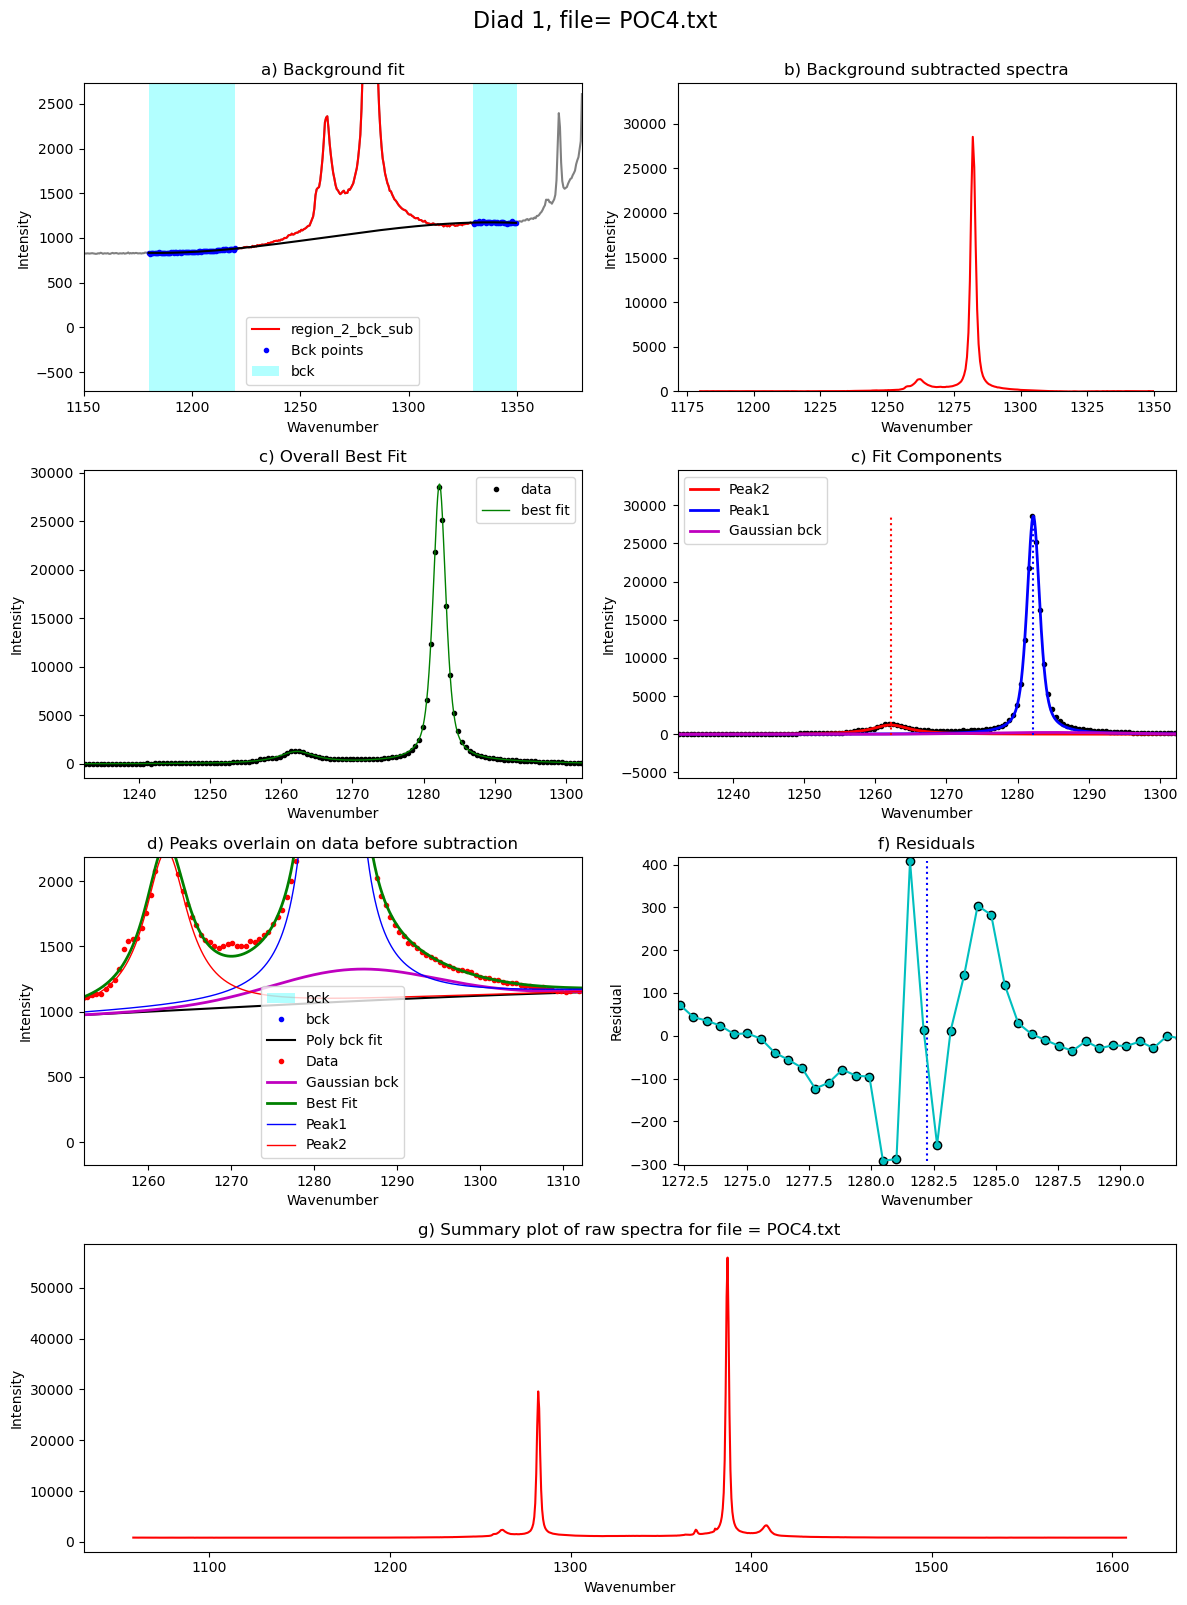

In [16]:
Diad1_fit=pf.fit_diad_1_w_bck(config1=diad1_fit_config_init,
config2=diad_id_config, peak_pos_voigt=diad1_peaks,
path=spectra_path, filename=filename_Weak, filetype=filetype, close_figure=False)
Diad1_fit

In [17]:
### Now lets update the tweakable parameters with the sigma values
diad1_fit_config=diad1_fit_config_init
diad1_fit_config.diad_sigma=Diad1_fit['Diad1_Voigt_Sigma'][0]
diad1_fit_config.diad_amplitude=Diad1_fit['Diad1_Voigt_Area'][0]
diad1_fit_config.HB_amplitude=Diad1_fit['HB1_Area'][0]
diad1_fit_config.sigma_allowance=2
diad1_fit_config

diad1_fit_config(model_name='PseudoVoigtModel', peak_pos_gauss=1287, gauss_sigma=20, gauss_amp=3000, diad_sigma=1.0758527298958498, sigma_allowance=2, N_poly_bck_diad1=3, lower_bck_diad1=(1180, 1220), upper_bck_diad1=(1330, 1350), diad_amplitude=84972.56169418503, HB_amplitude=12239.156336749988, x_range_baseline=30, y_range_baseline=1000, plot_figure=True, dpi=200, x_range_residual=10, return_other_params=False)

## Fit diad 2

In [18]:
diad2_fit_config_init=pf.diad2_fit_config(model_name=model_name,
    peak_pos_gauss=1385, lower_bck_diad2=(1310, 1340),
    gauss_sigma=20,                                          
diad_sigma=1,  N_poly_bck_diad2=3,
HB_amplitude=10000,                                          
x_range_residual=30, y_range_baseline=1000, 
diad_amplitude=100000, 
x_range_baseline=30)
diad2_fit_config_init

diad2_fit_config(model_name='PseudoVoigtModel', peak_pos_gauss=1385, gauss_sigma=20, gauss_amp=3000, diad_sigma=1, C13_sigma=0.1, sigma_allowance=10, N_poly_bck_diad2=3, lower_bck_diad2=(1310, 1340), upper_bck_diad2=(1440, 1470), diad_amplitude=100000, HB_amplitude=10000, x_range_baseline=30, y_range_baseline=1000, plot_figure=True, dpi=200, x_range_residual=30, return_other_params=False)

3rd peak cent
1408.239942
3rd peak cent
1369.390939


Diad2_Combofit_Cent  Diad2_Voigt_Cent  Diad2_Voigt_Area  Diad2_Voigt_Sigma  \
0          1386.921987       1386.921937      154793.33217           1.010704   

  Diad2_Voigt_Gamma     HB2_Cent      HB2_Area    C13_Cent    C13_Area  \
0              None  1408.259456  16016.620619  1369.56896  1853.06993   

   Diad2_Combofit_Height  Residual_Diad2  Diad2_Prop_Lor   Gauss_Cent  \
0           55482.667503       49.546871        0.726341  1385.752069   

     Gauss_Area  Gauss_Sigma  Diad2_refit  
0  12724.306074    14.107395        False

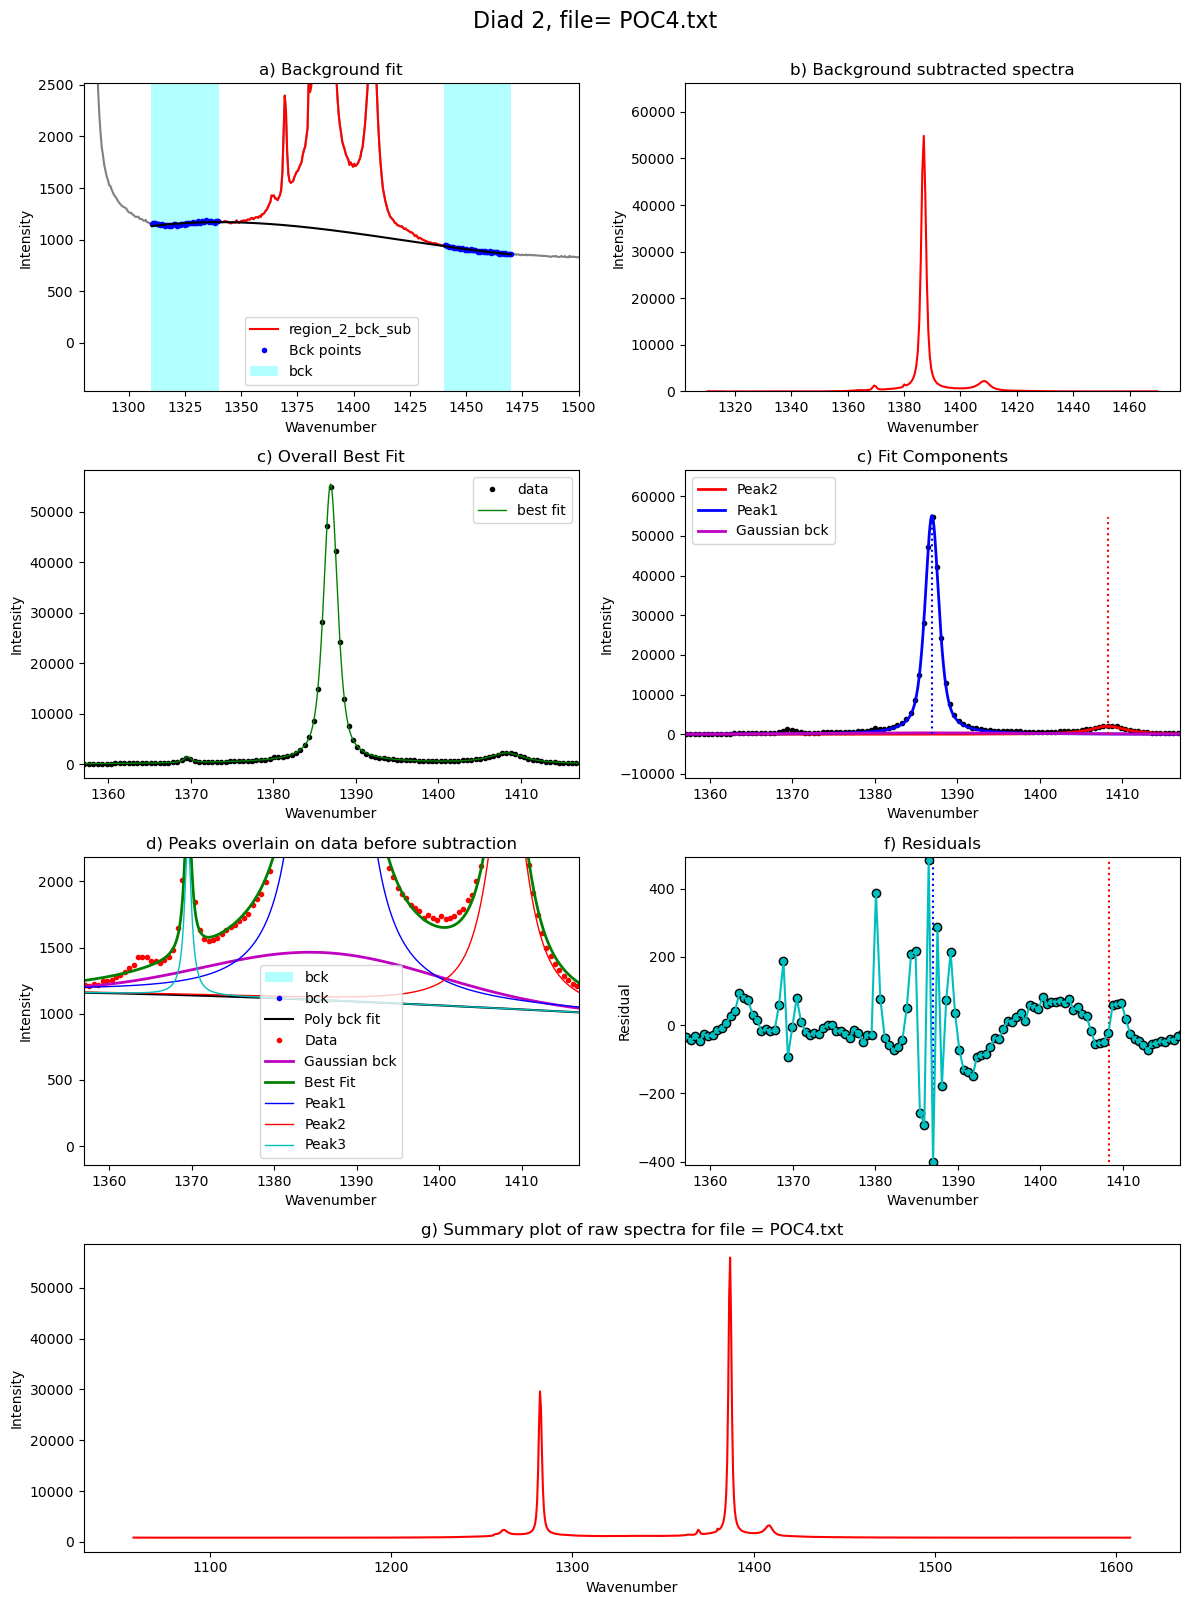

In [19]:
Diad2_fit=pf.fit_diad_2_w_bck(config1=diad2_fit_config_init,
    config2=diad_id_config, peak_pos_voigt=diad2_peaks,
path=spectra_path, filename=filename_Weak, filetype=filetype, close_figure=False)
Diad2_fit.to_clipboard(excel=True)
Diad2_fit

In [20]:
138852.362885/14540.869329

9.54911014901123

In [21]:
# Update param with new sigma
diad2_fit_config=diad2_fit_config_init
diad2_fit_config.diad_sigma=Diad2_fit['Diad2_Voigt_Sigma'][0]
diad2_fit_config.sigma_allowance=2
diad2_fit_config.diad_amplitude=Diad2_fit['Diad2_Voigt_Area'][0]
diad2_fit_config.HB_amplitude=Diad2_fit['HB2_Area'][0]
diad2_fit_config

diad2_fit_config(model_name='PseudoVoigtModel', peak_pos_gauss=1385, gauss_sigma=20, gauss_amp=3000, diad_sigma=1.0107043506988336, C13_sigma=0.1, sigma_allowance=2, N_poly_bck_diad2=3, lower_bck_diad2=(1310, 1340), upper_bck_diad2=(1440, 1470), diad_amplitude=154793.33217022268, HB_amplitude=16016.620619355748, x_range_baseline=30, y_range_baseline=1000, plot_figure=True, dpi=200, x_range_residual=30, return_other_params=False)

## You can also try looping if all your spectra are pretty similar

  0%|                                                                                            | 0/8 [00:00<?, ?it/s]g:\my drive\berkeley_new\diadfit_outer\src\DiadFit\diads.py:725: UserWarning: Diad fit right at the lower limit of the allowed fit parameter, change diad_sigma in the  diad1 config file
  w.warn('Diad fit right at the lower limit of the allowed fit parameter, change diad_sigma in the  diad1 config file')
g:\my drive\berkeley_new\diadfit_outer\src\DiadFit\diads.py:741: UserWarning: Best fit Gauss  sigma is right at the lower limit of the allowed fit parameter, change gauss_sigma in the   diad1 config file
  w.warn('Best fit Gauss  sigma is right at the lower limit of the allowed fit parameter, change gauss_sigma in the   diad1 config file')
g:\my drive\berkeley_new\diadfit_outer\src\DiadFit\diads.py:744: UserWarning: Best fit Gauss amplitude is right at the upper limit of the allowed fit parameter, change gauss_amp in the diad1 config file
  w.warn('Best fit Gauss ampli

3rd peak cent
1408.770036
3rd peak cent
1369.390939


 12%|██████████▌                                                                         | 1/8 [00:03<00:21,  3.10s/it]g:\my drive\berkeley_new\diadfit_outer\src\DiadFit\diads.py:725: UserWarning: Diad fit right at the lower limit of the allowed fit parameter, change diad_sigma in the  diad1 config file
  w.warn('Diad fit right at the lower limit of the allowed fit parameter, change diad_sigma in the  diad1 config file')
g:\my drive\berkeley_new\diadfit_outer\src\DiadFit\diads.py:741: UserWarning: Best fit Gauss  sigma is right at the lower limit of the allowed fit parameter, change gauss_sigma in the   diad1 config file
  w.warn('Best fit Gauss  sigma is right at the lower limit of the allowed fit parameter, change gauss_sigma in the   diad1 config file')
g:\my drive\berkeley_new\diadfit_outer\src\DiadFit\diads.py:744: UserWarning: Best fit Gauss amplitude is right at the upper limit of the allowed fit parameter, change gauss_amp in the diad1 config file
  w.warn('Best fit Gauss ampli

3rd peak cent
1408.239942
3rd peak cent
1369.390939


 25%|█████████████████████                                                               | 2/8 [00:06<00:19,  3.30s/it]

3rd peak cent
1408.770036
3rd peak cent
1369.390939


 38%|███████████████████████████████▌                                                    | 3/8 [00:12<00:21,  4.32s/it]

3rd peak cent
1408.770036
3rd peak cent
1369.390939


 50%|██████████████████████████████████████████                                          | 4/8 [00:17<00:18,  4.63s/it]

3rd peak cent
1408.239942
3rd peak cent
1369.390939


 62%|████████████████████████████████████████████████████▌                               | 5/8 [00:21<00:13,  4.43s/it]

3rd peak cent
1408.239942
3rd peak cent
1369.390939


 75%|███████████████████████████████████████████████████████████████                     | 6/8 [00:26<00:09,  4.55s/it]

3rd peak cent
1408.24
3rd peak cent
1369.39


 88%|█████████████████████████████████████████████████████████████████████████▌          | 7/8 [00:32<00:05,  5.02s/it]

3rd peak cent
1408.239942
3rd peak cent
1369.390939


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:35<00:00,  4.48s/it]


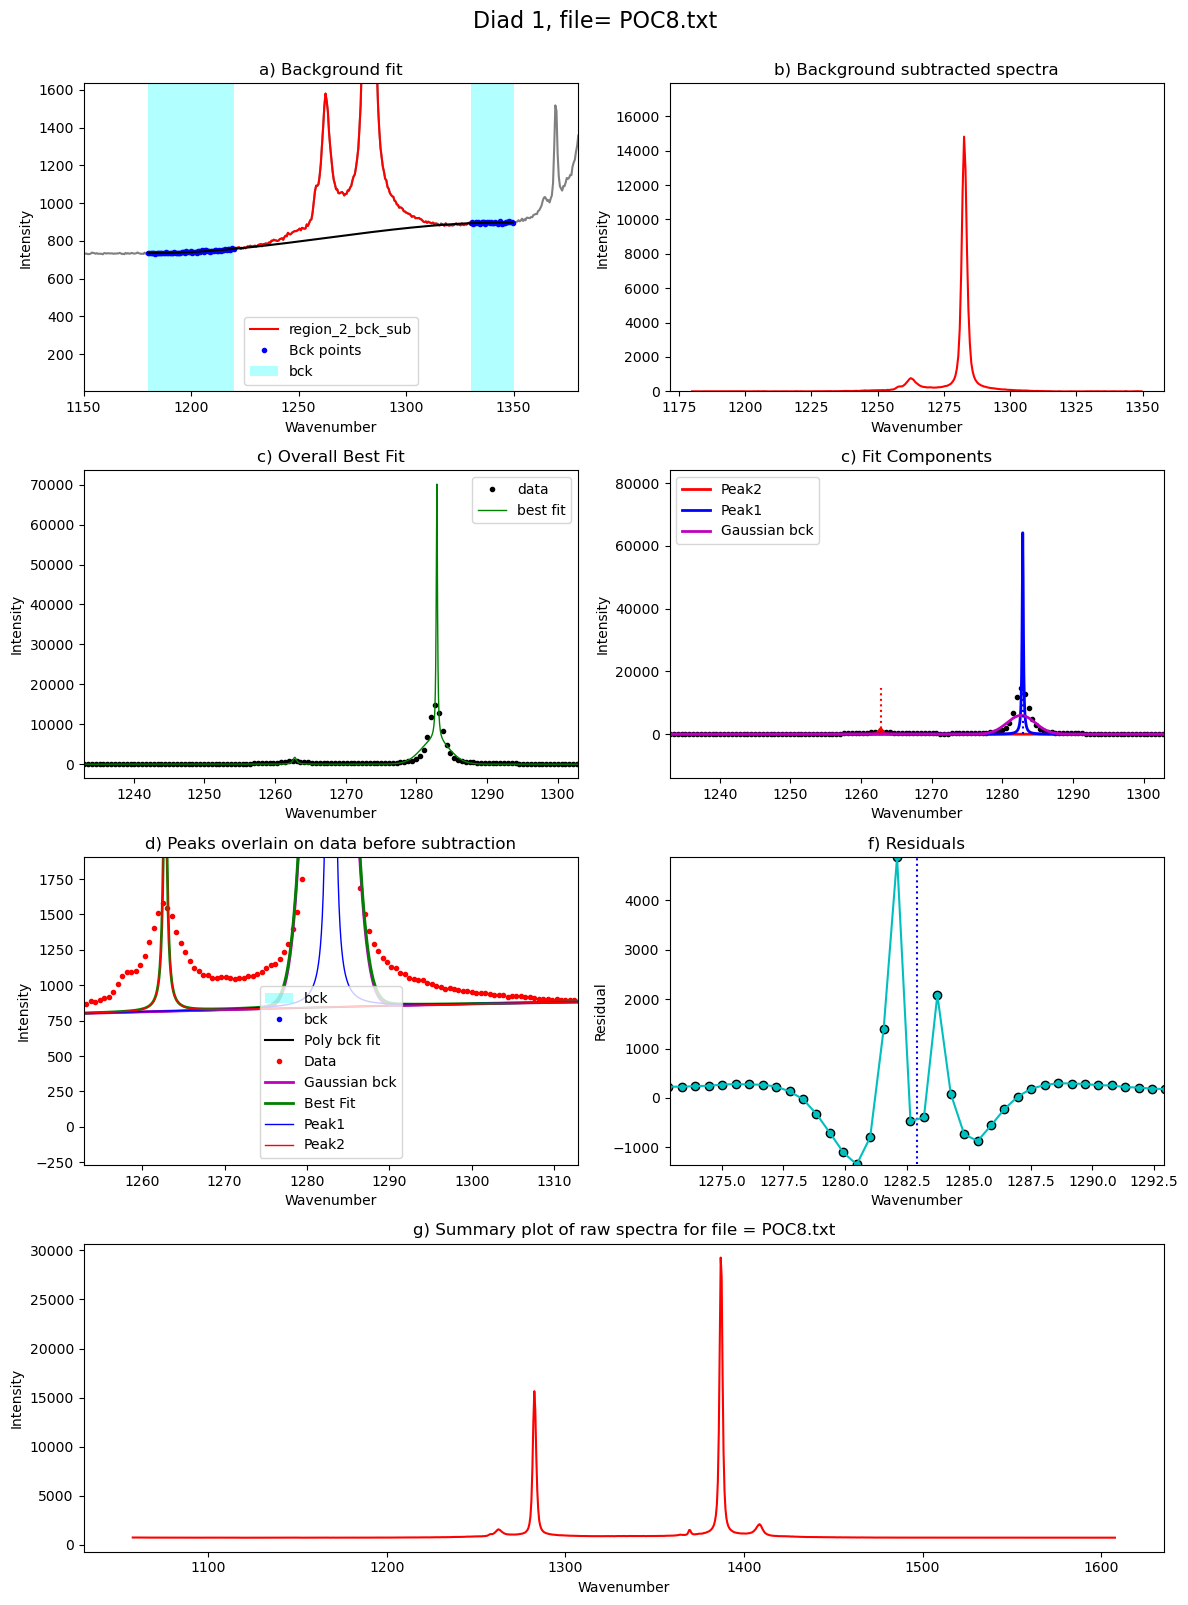

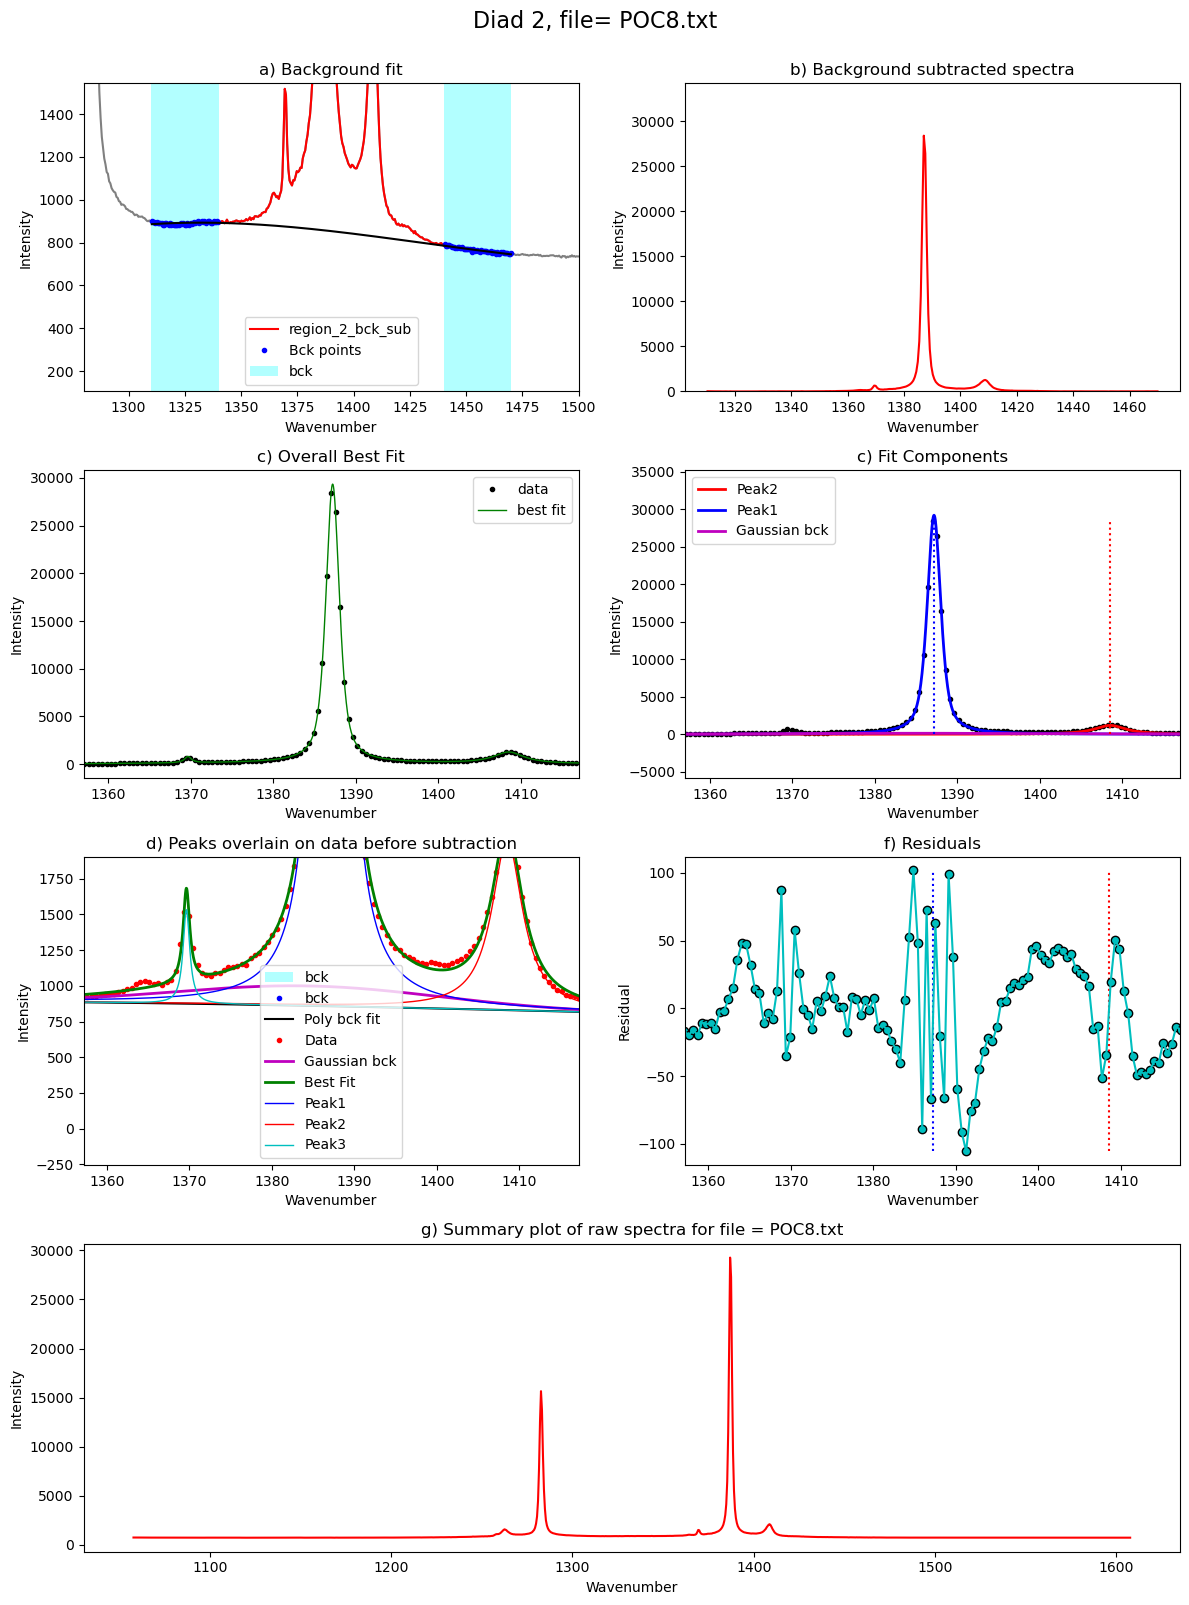

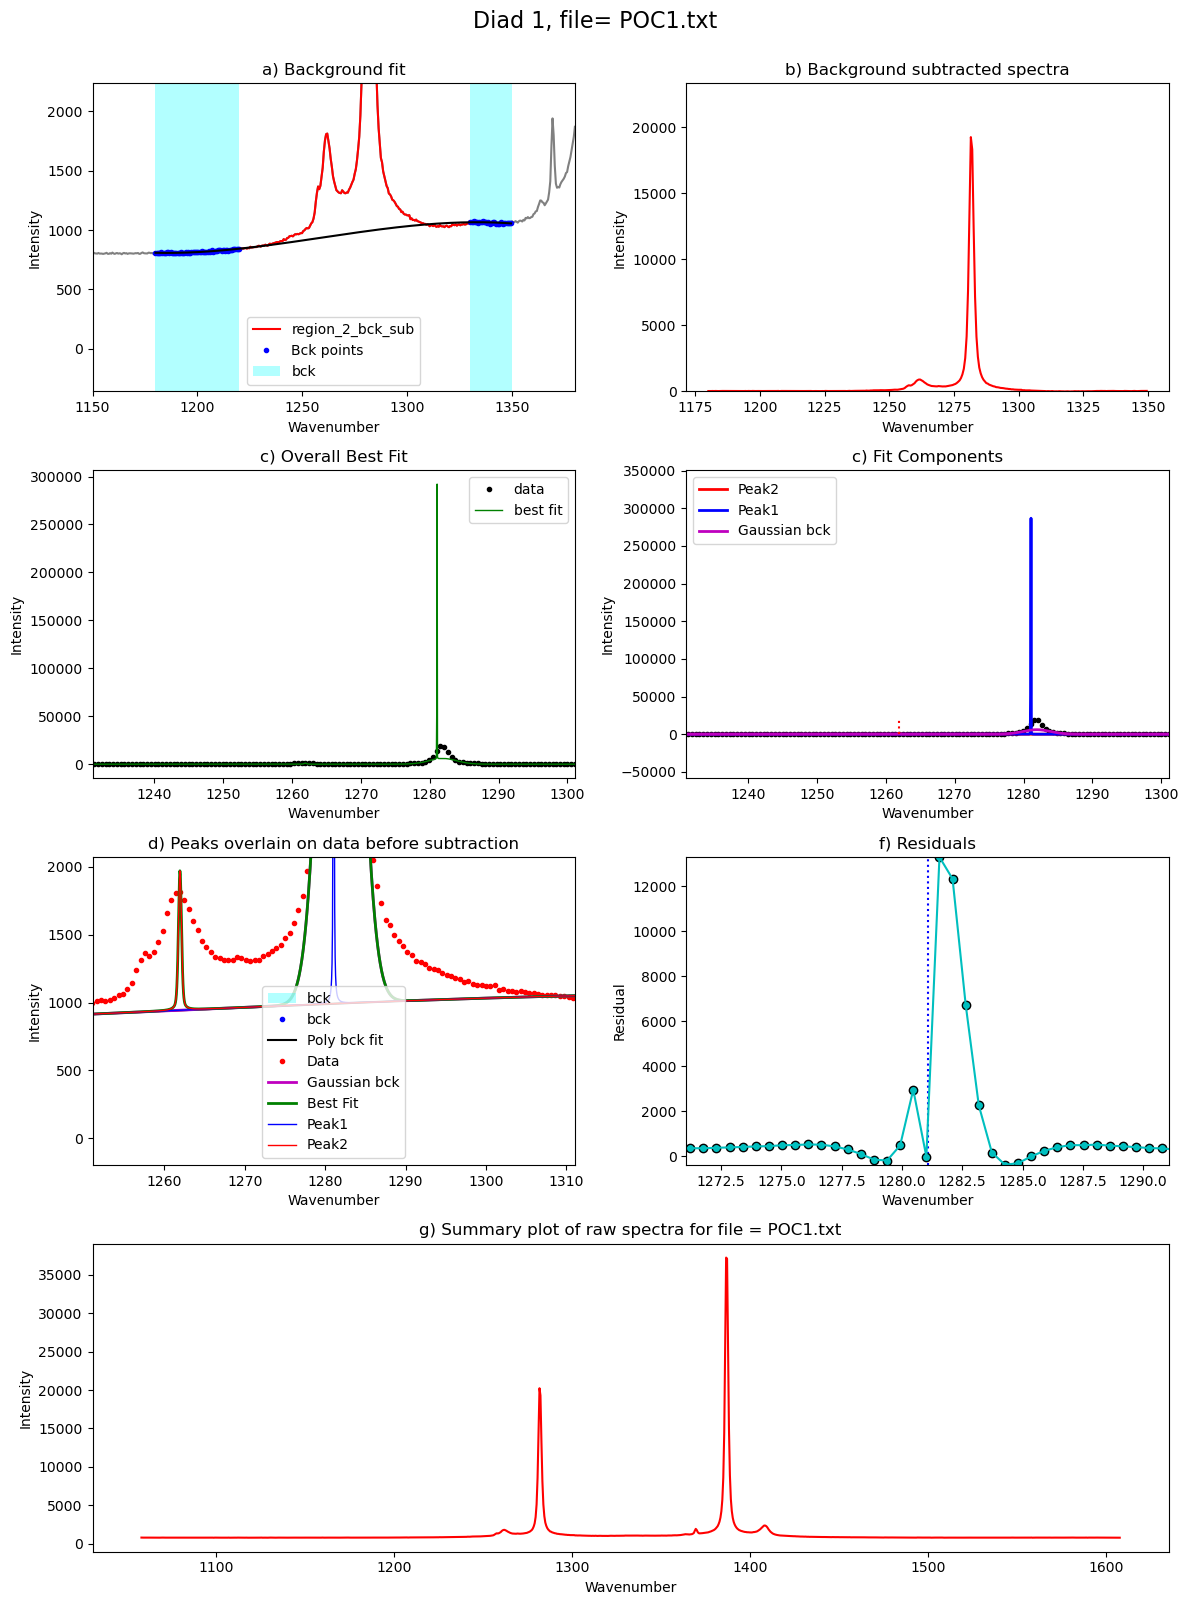

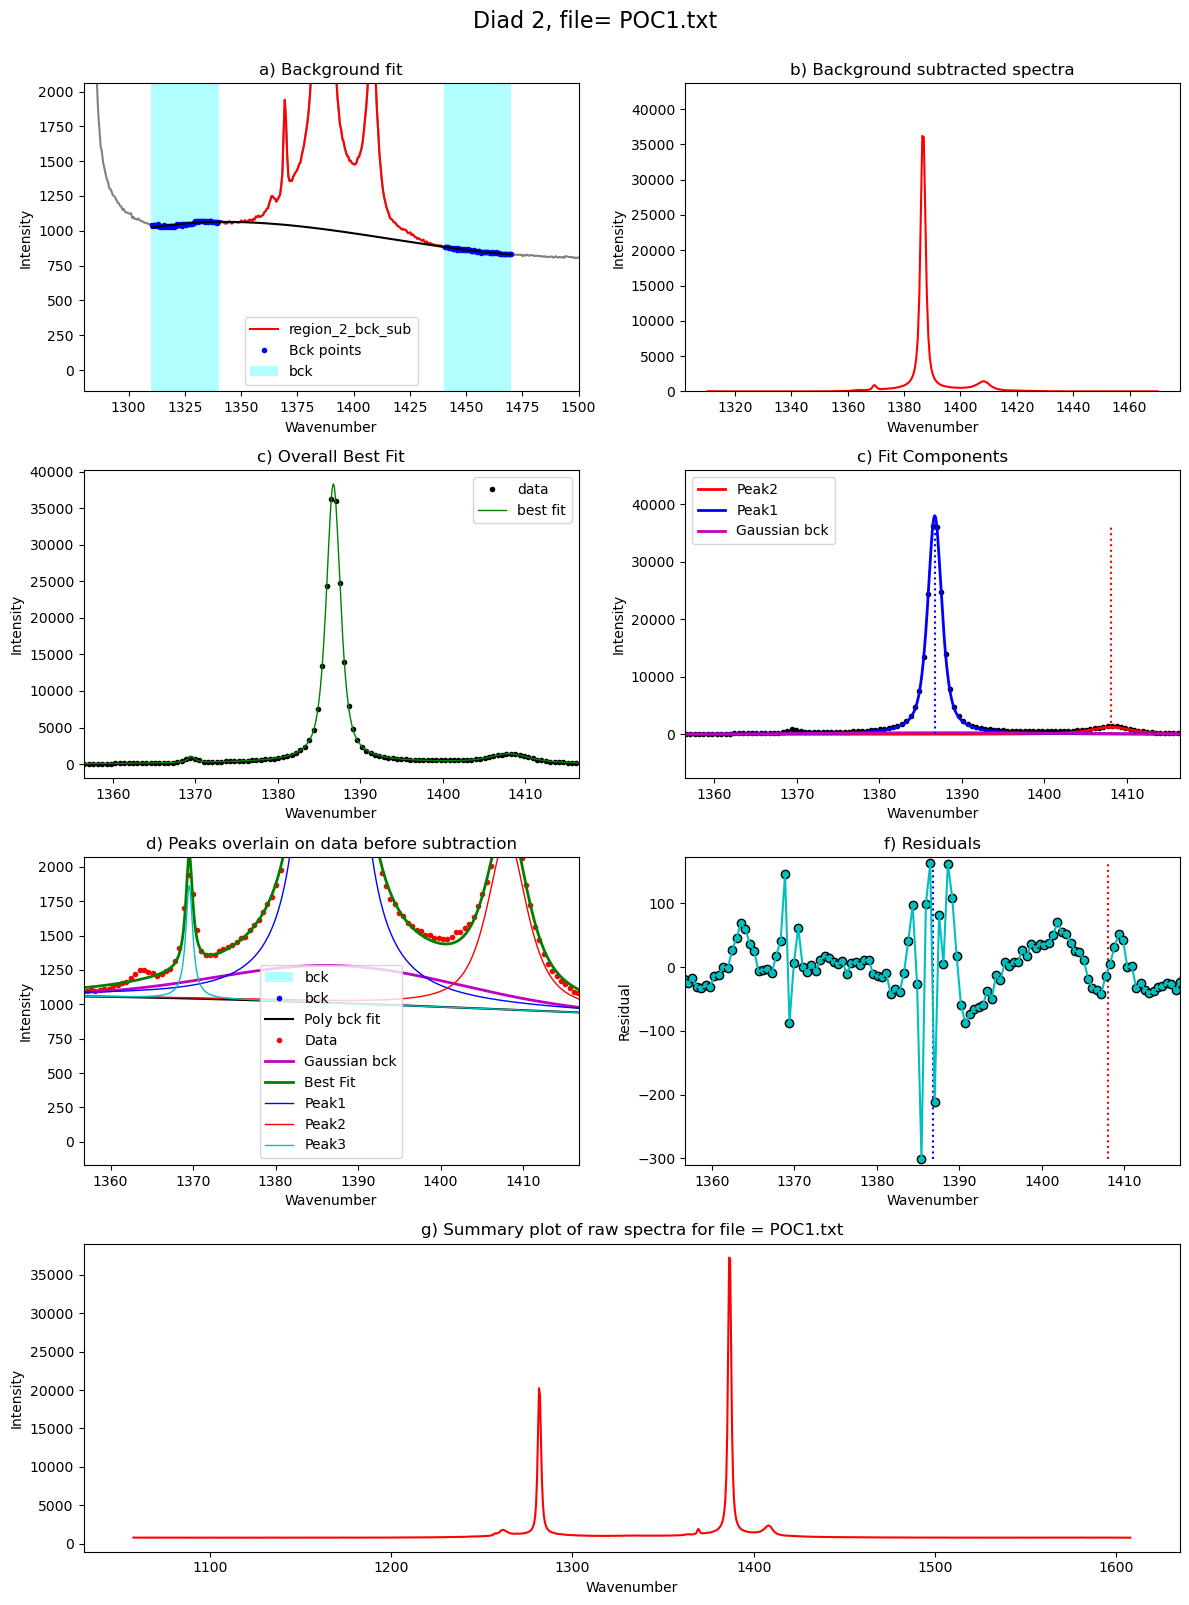

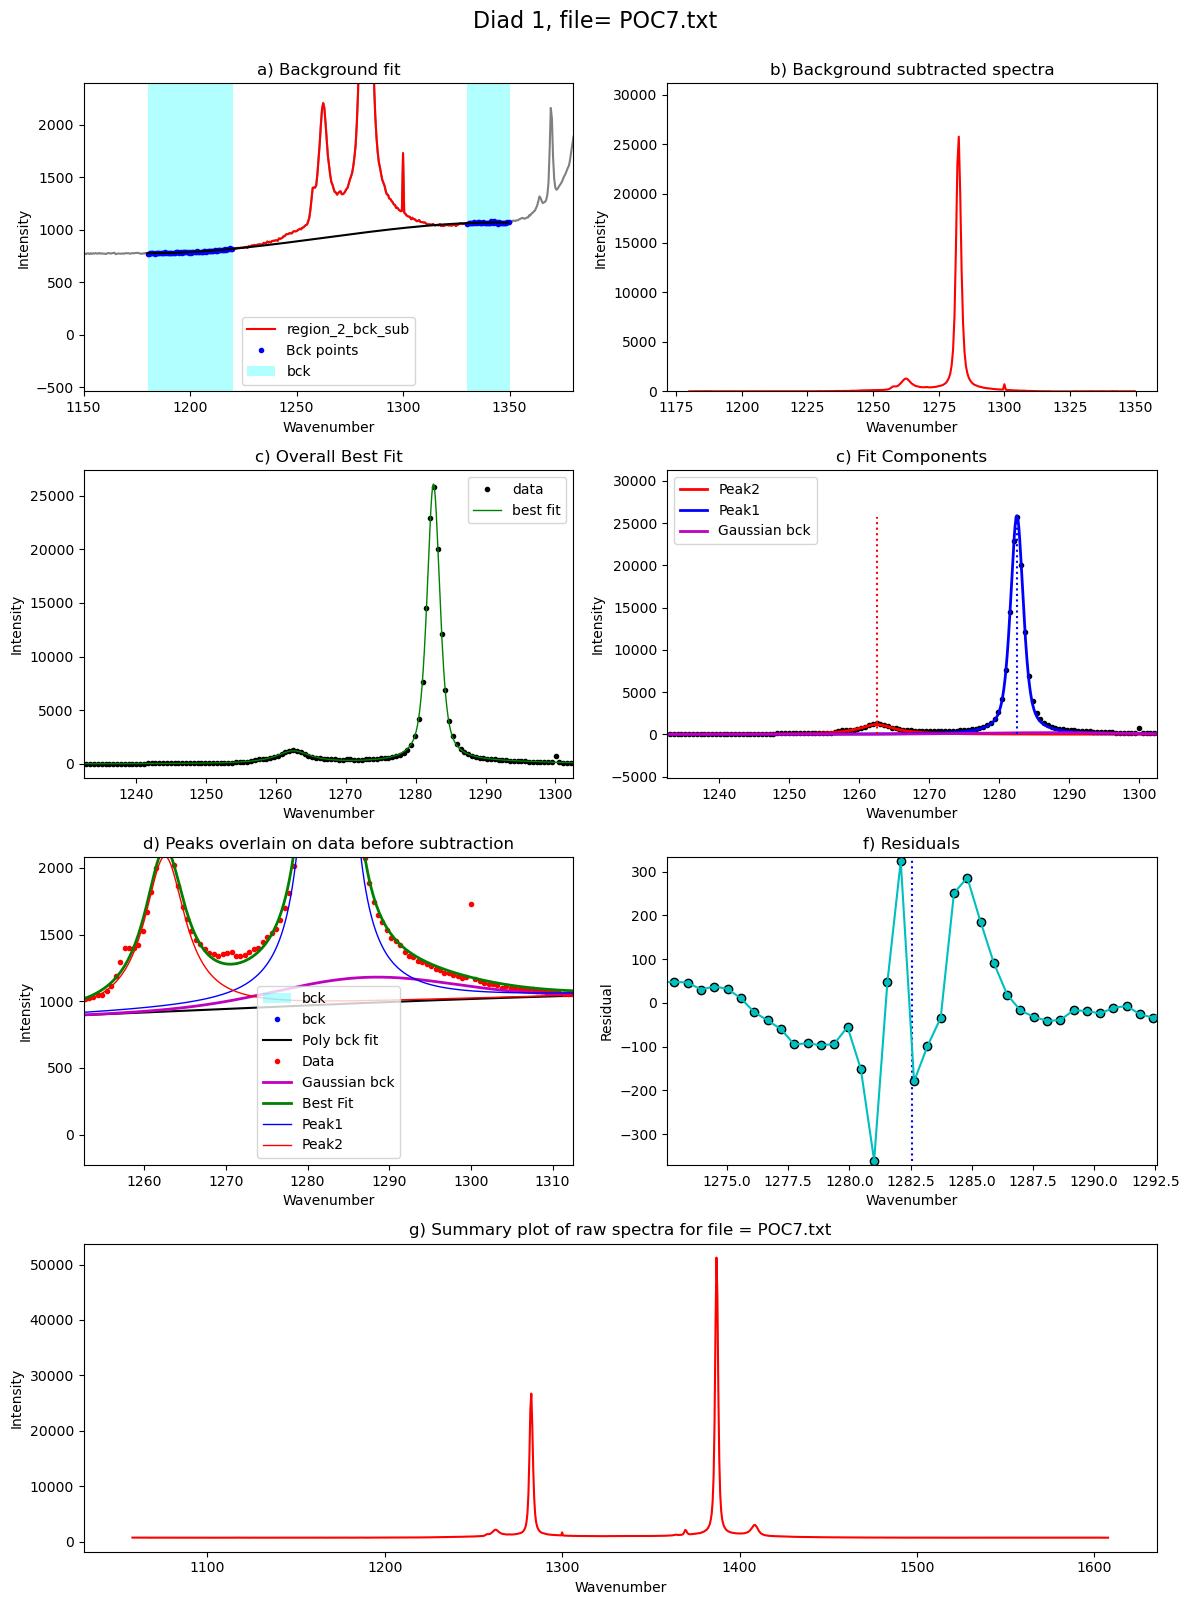

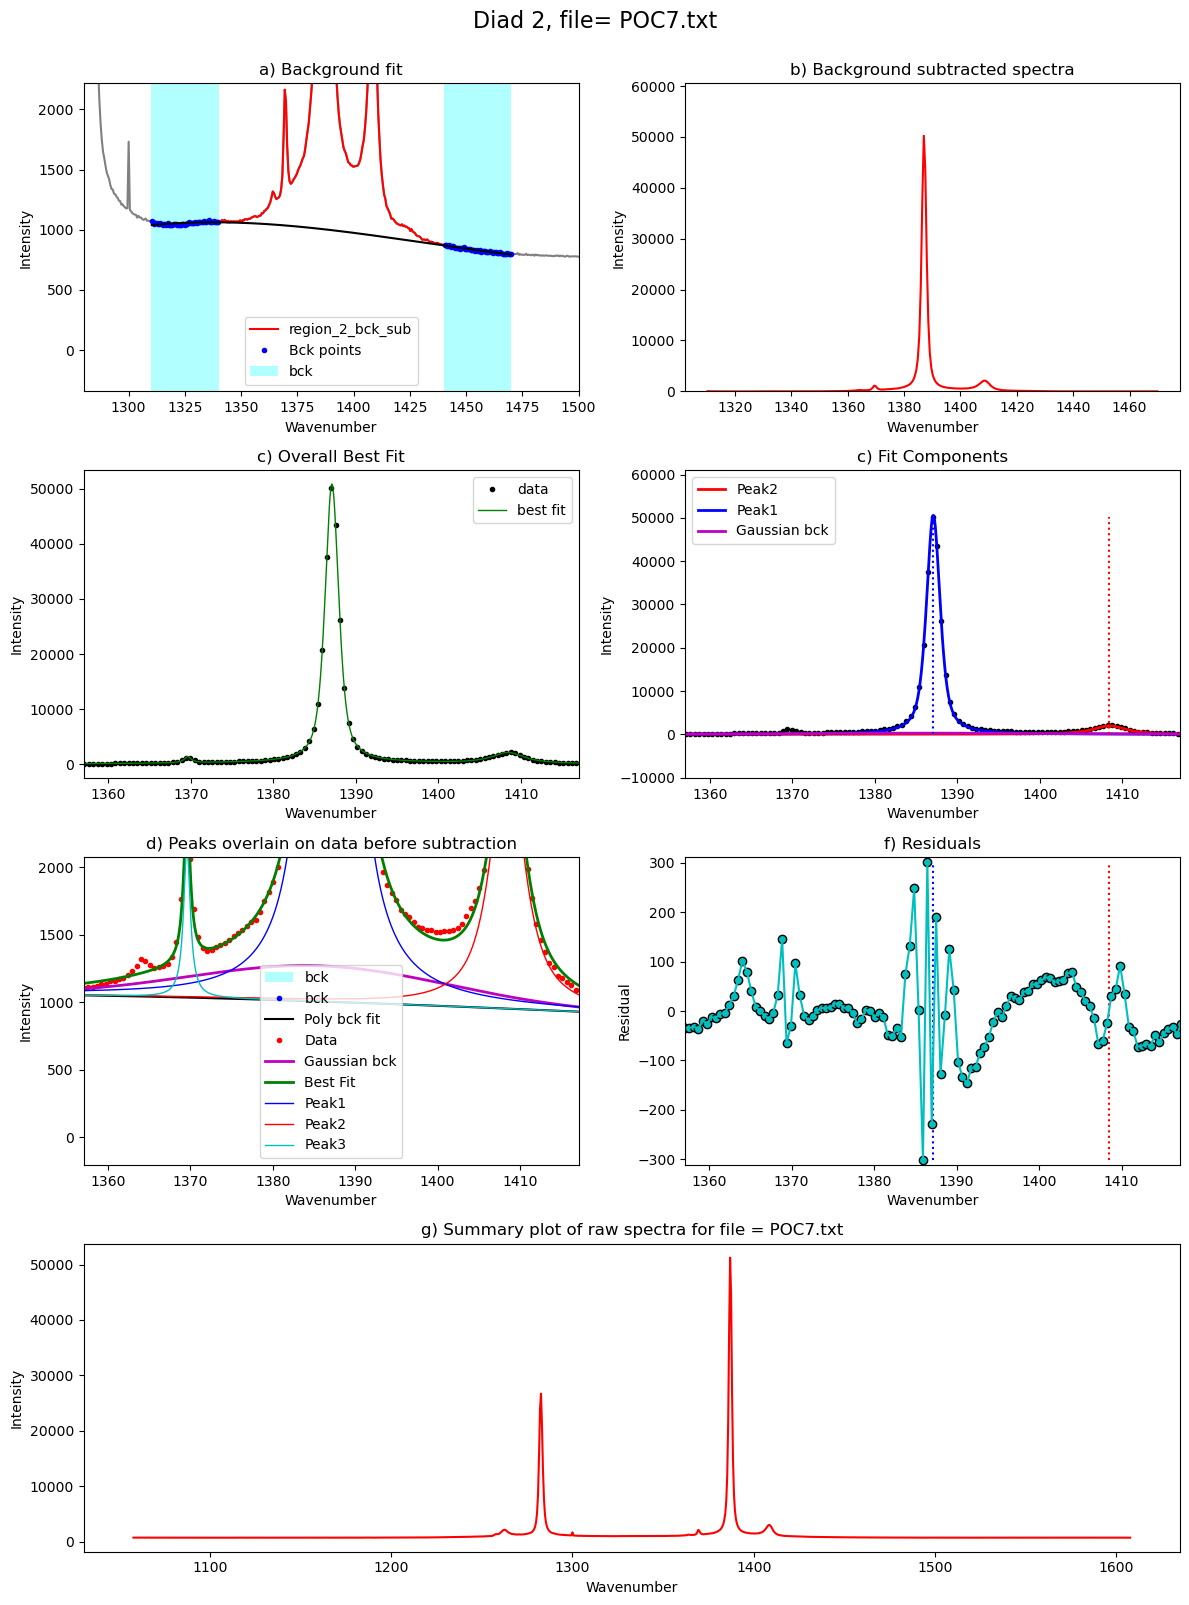

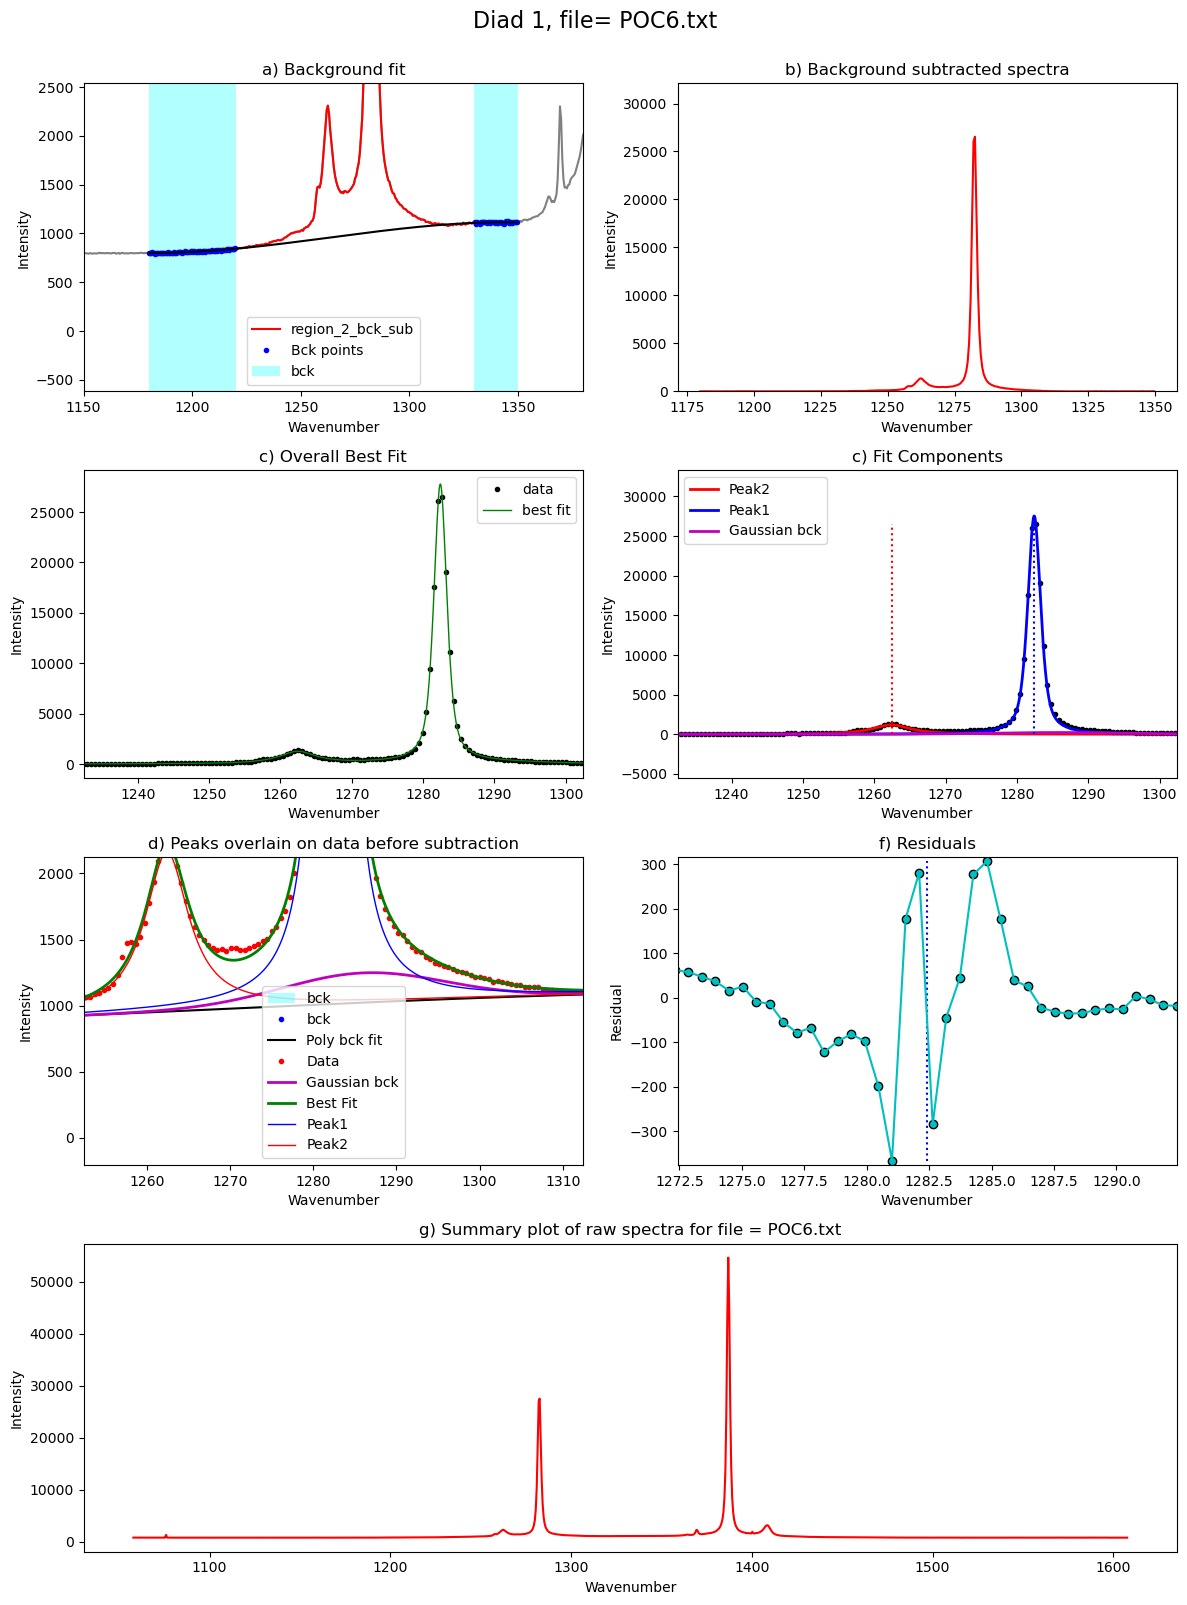

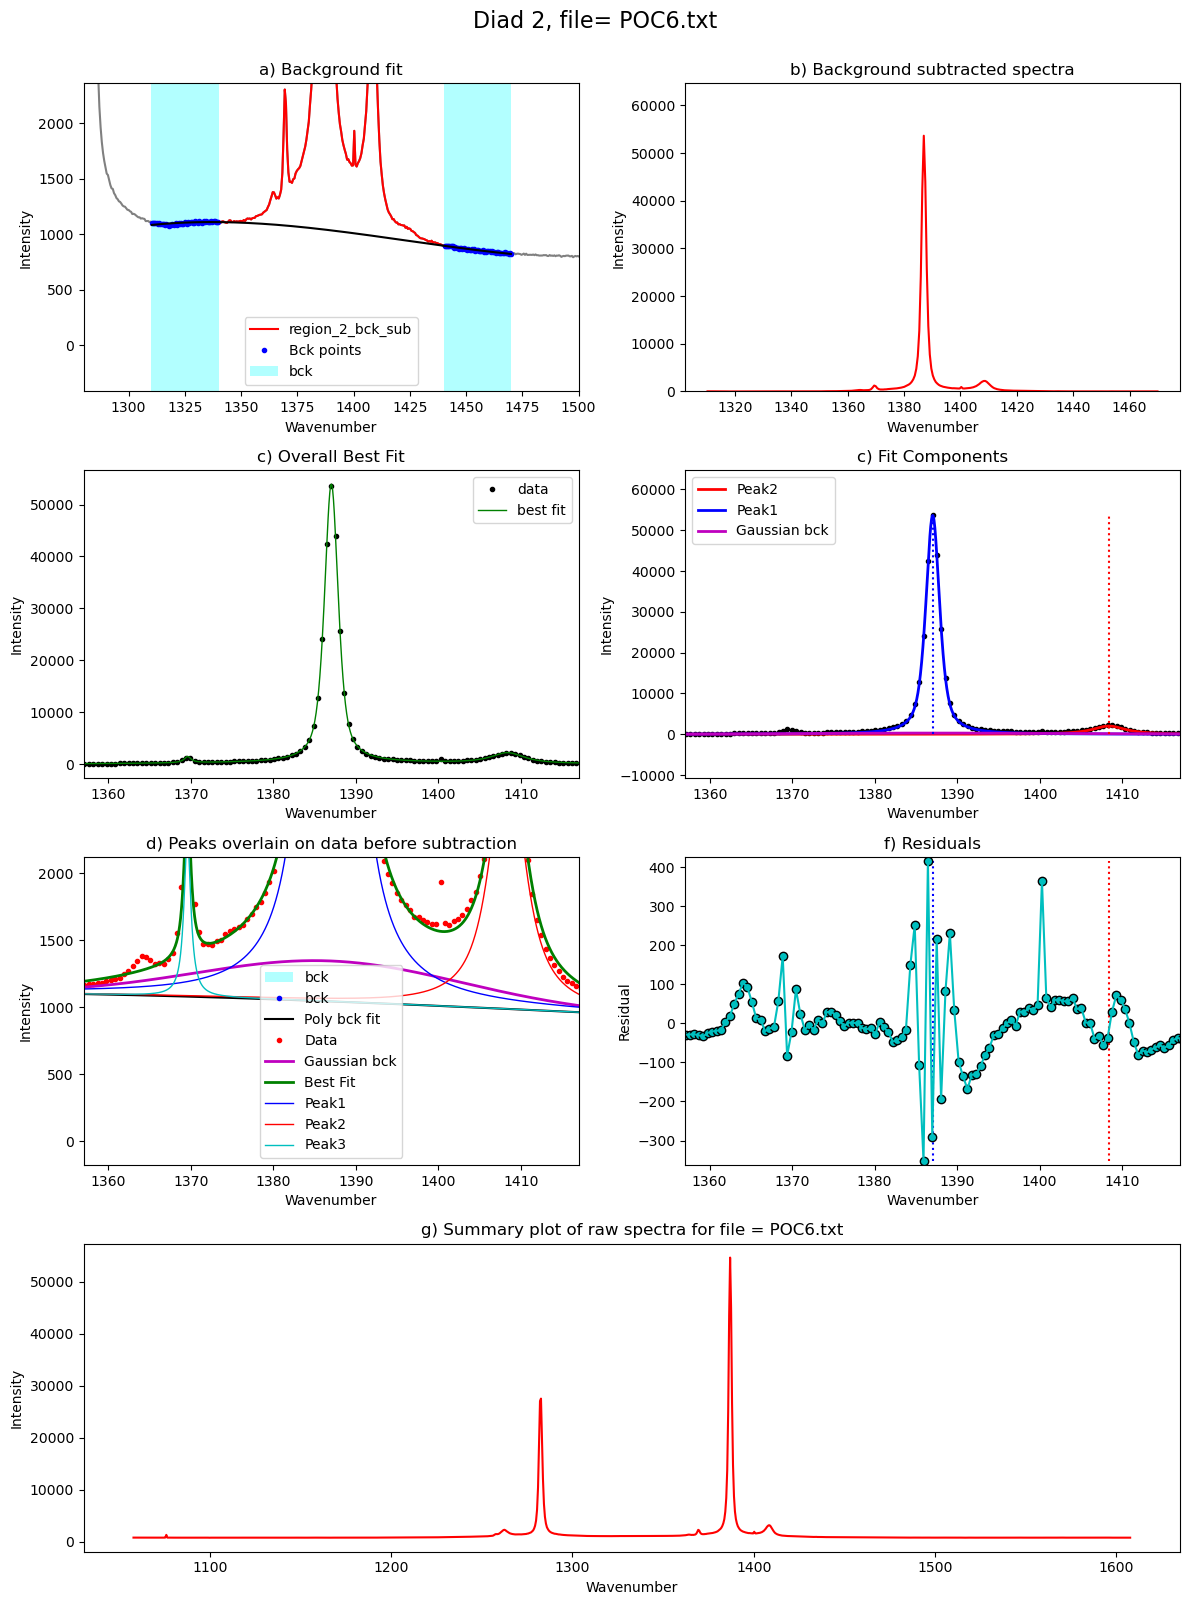

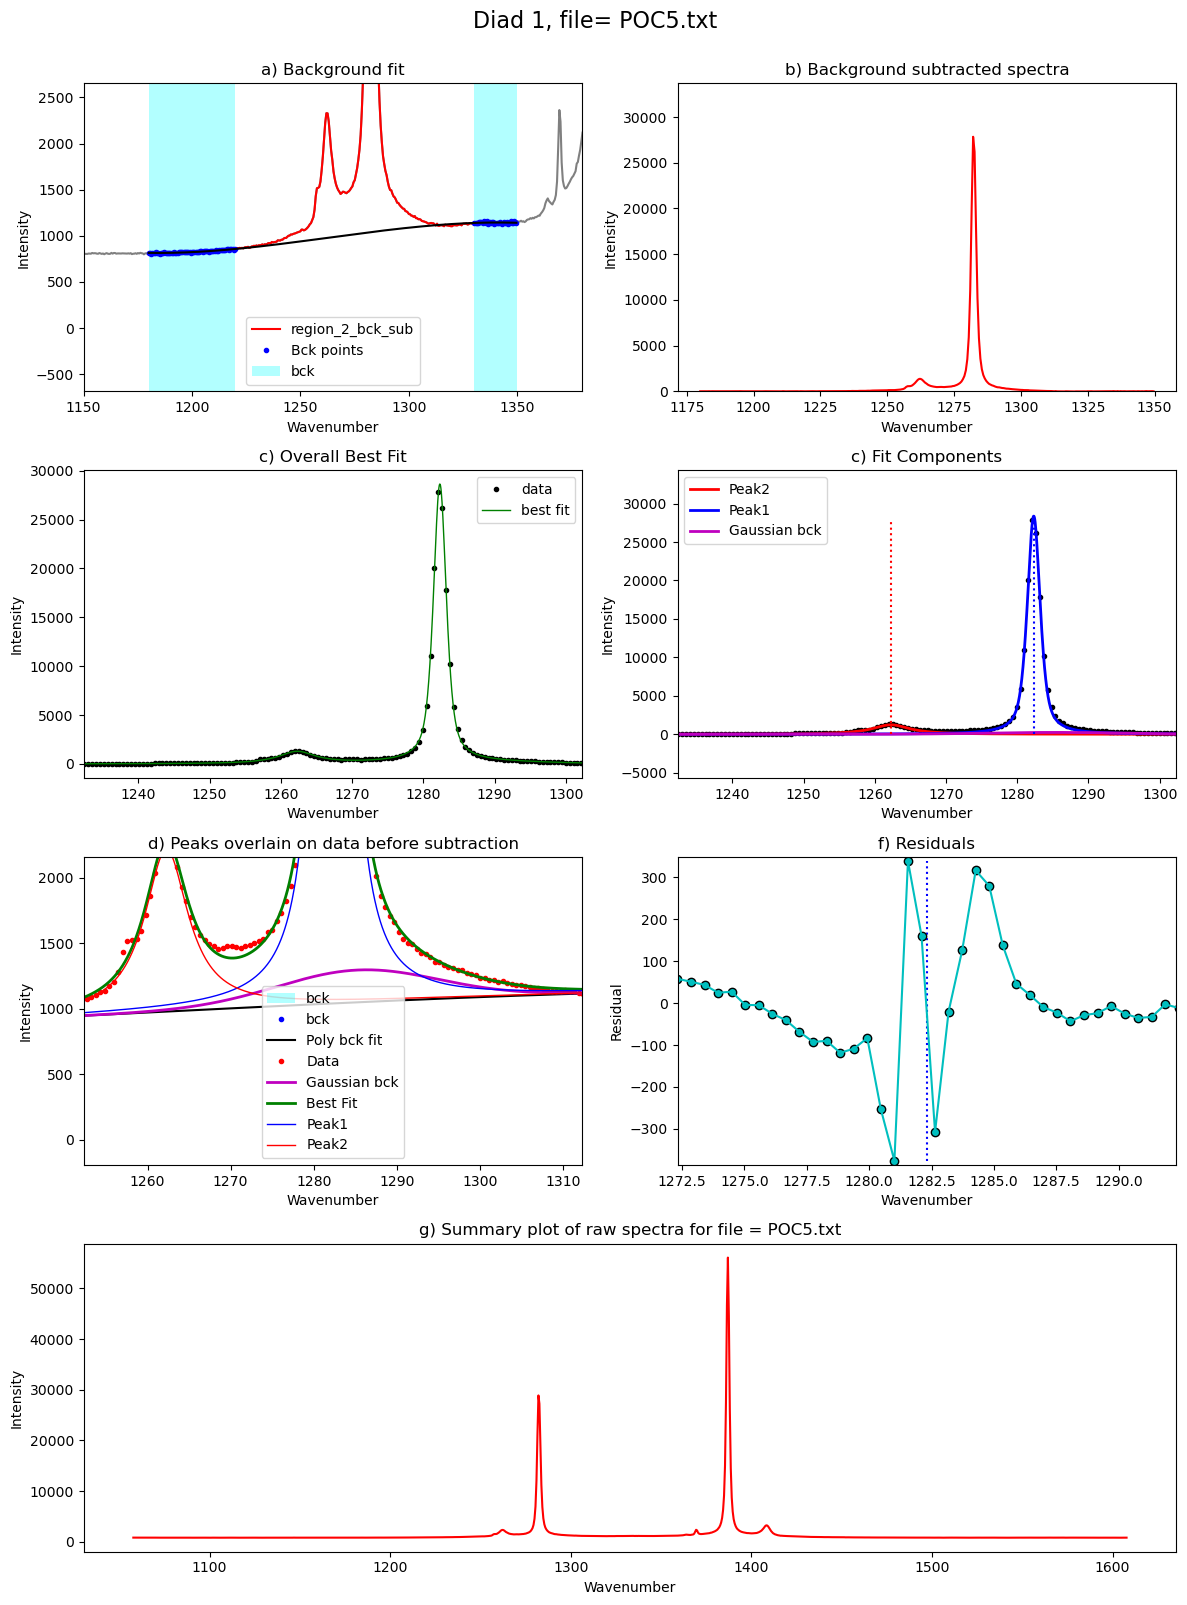

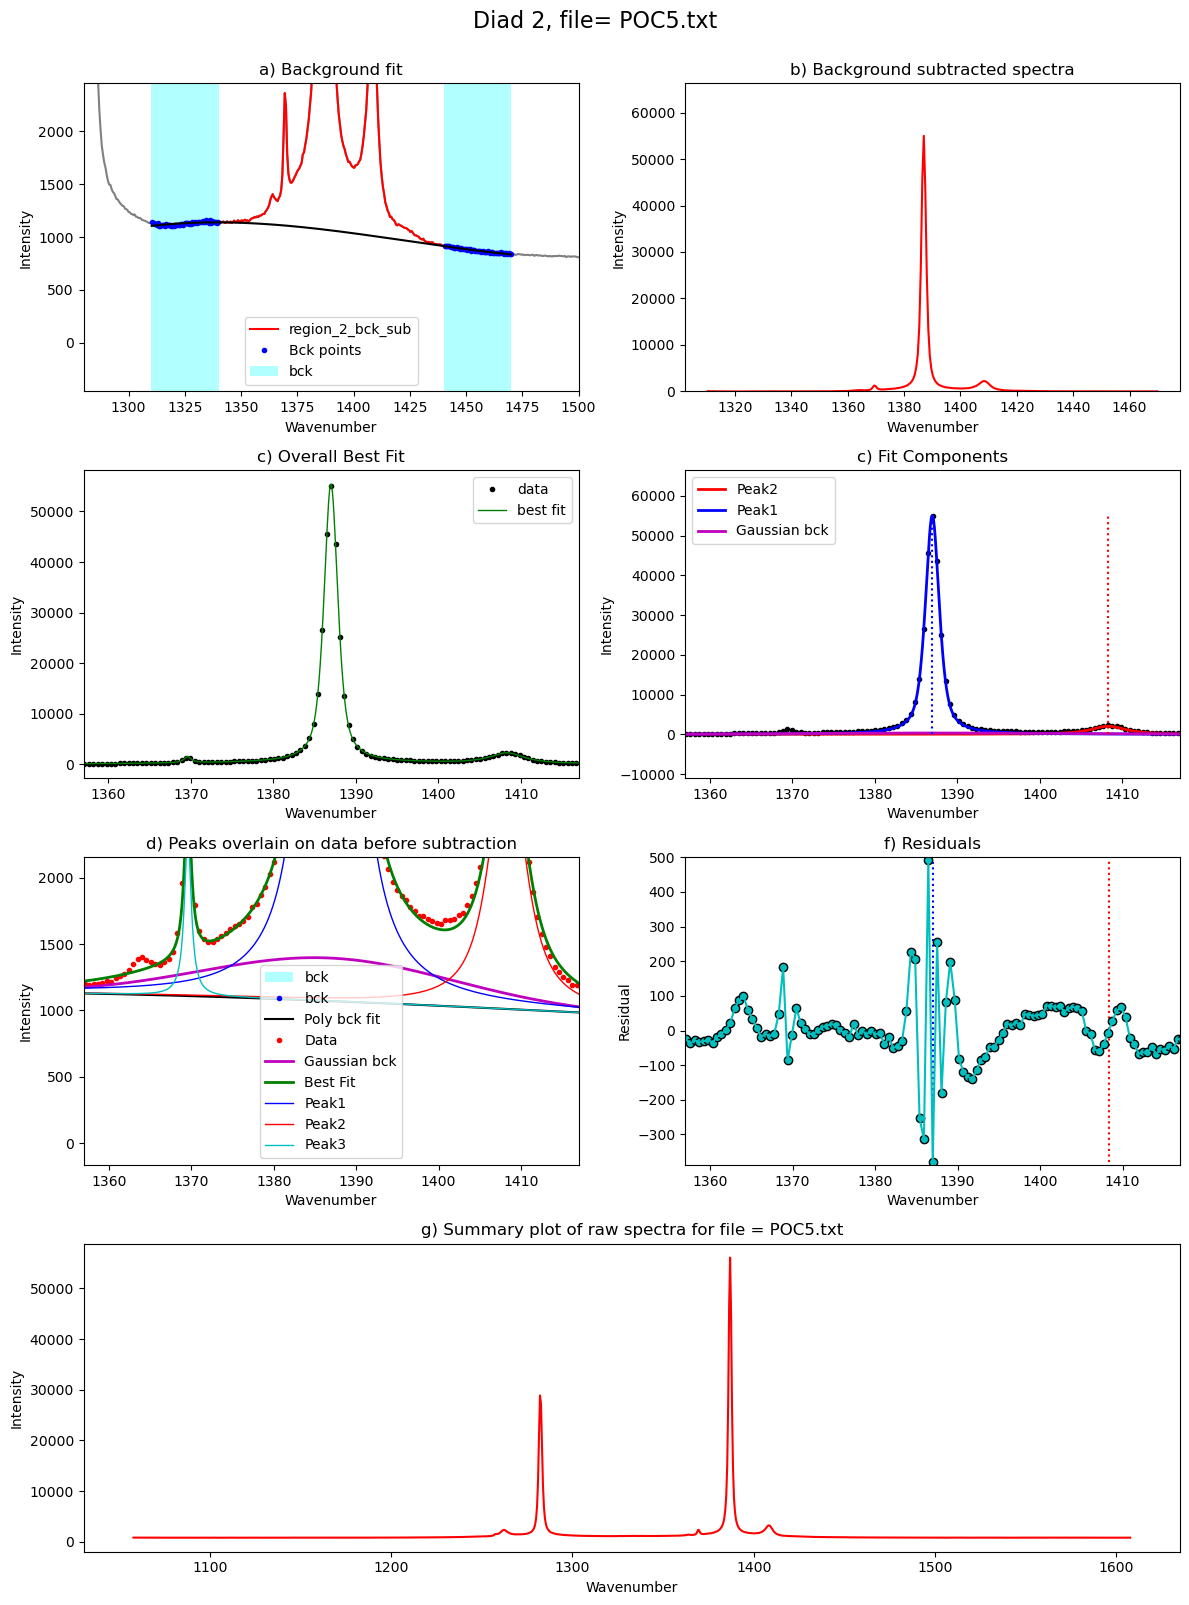

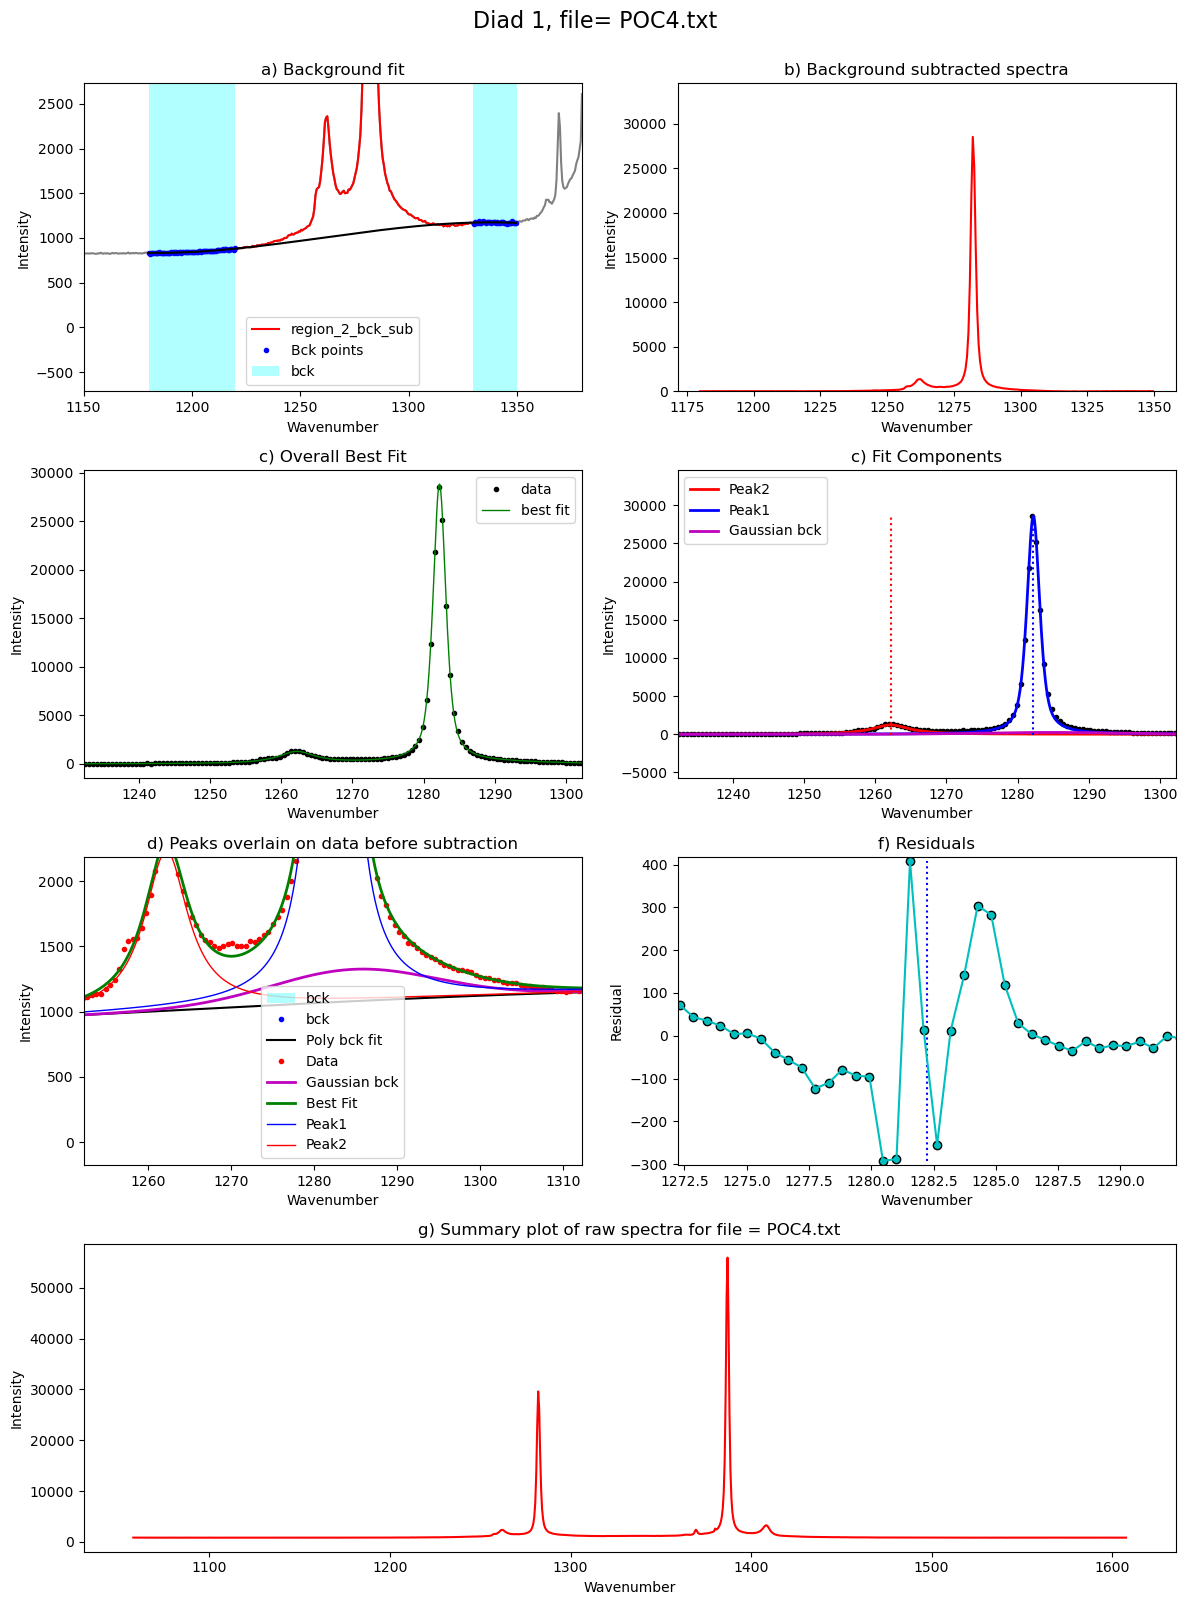

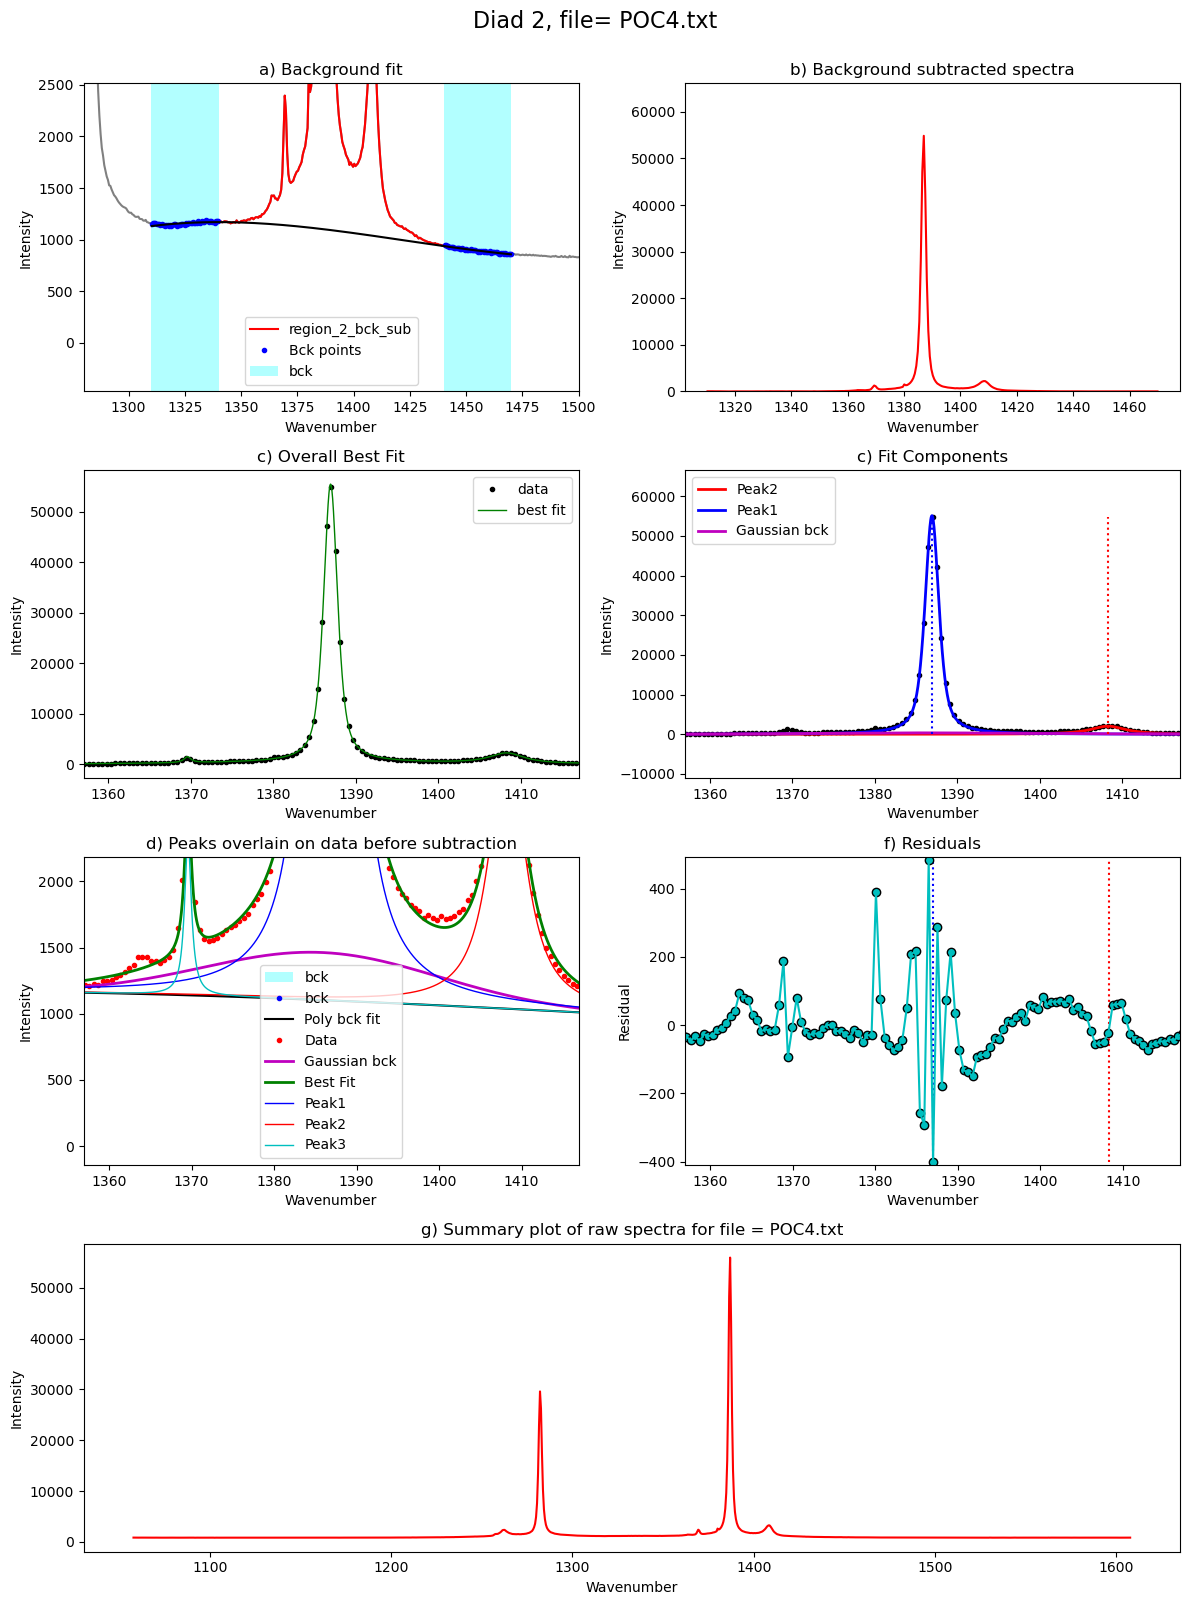

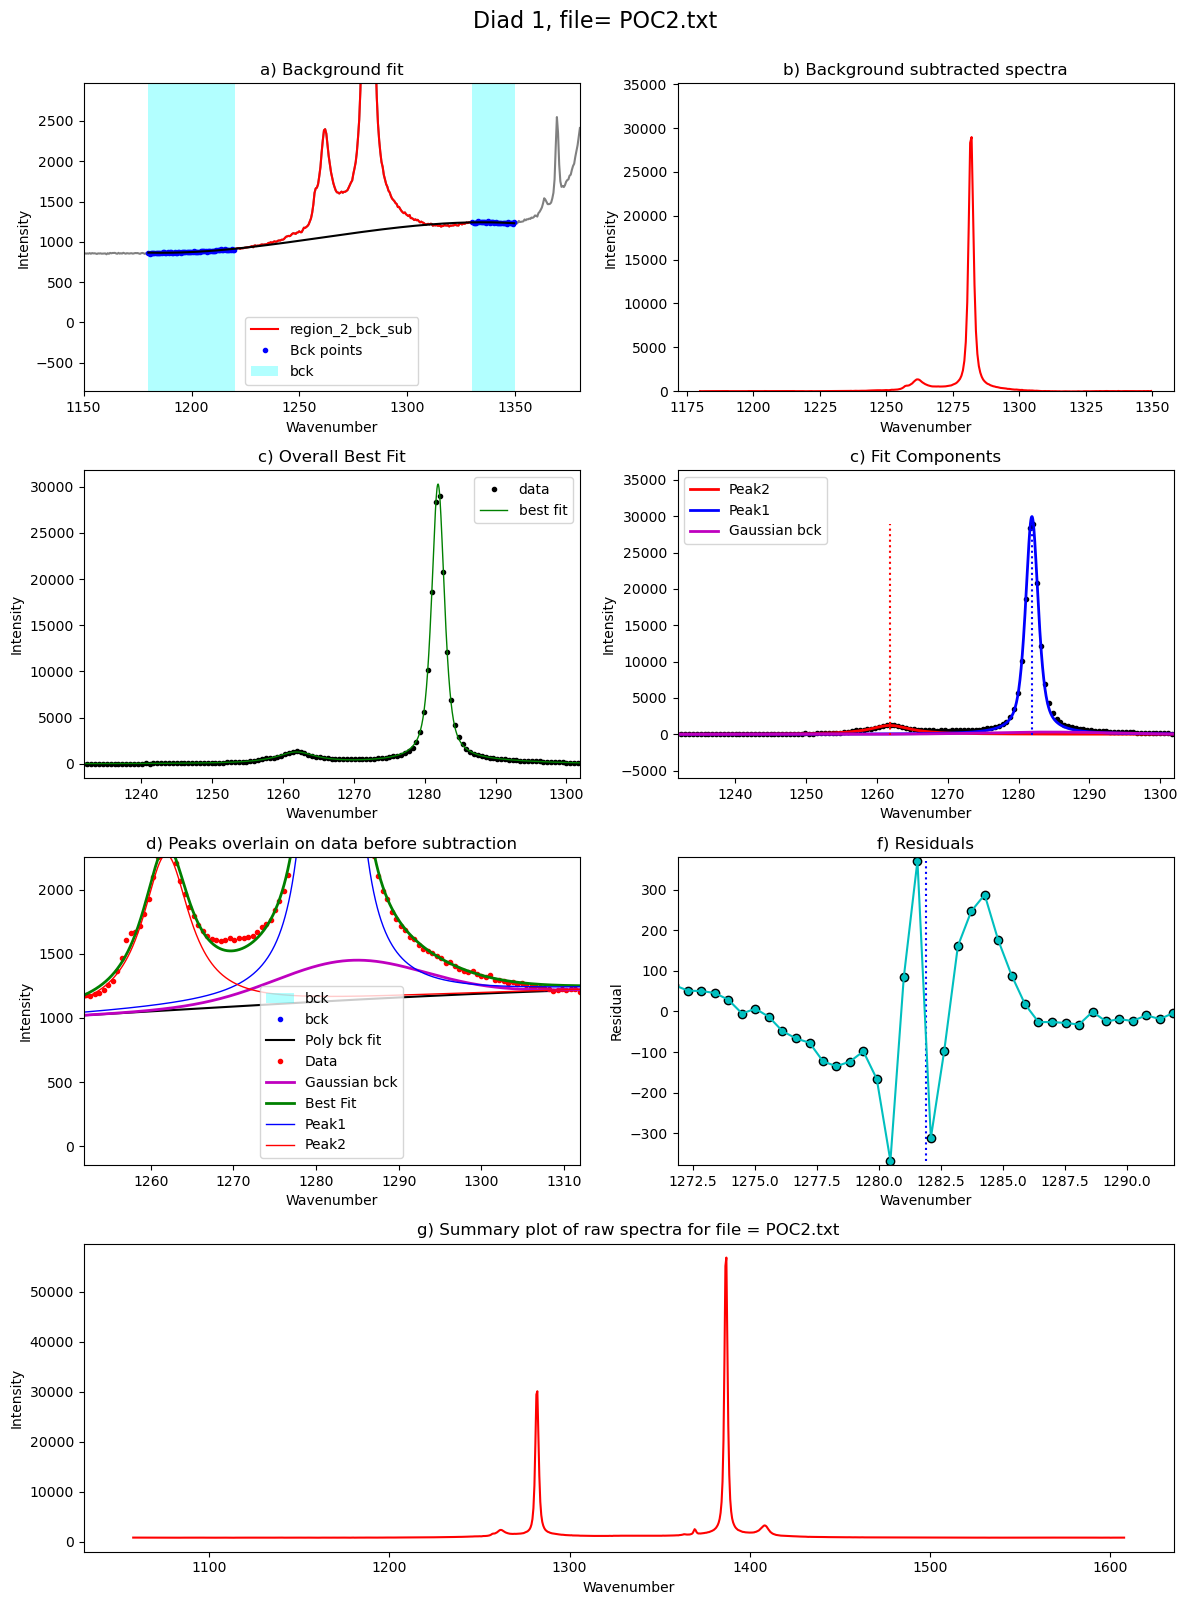

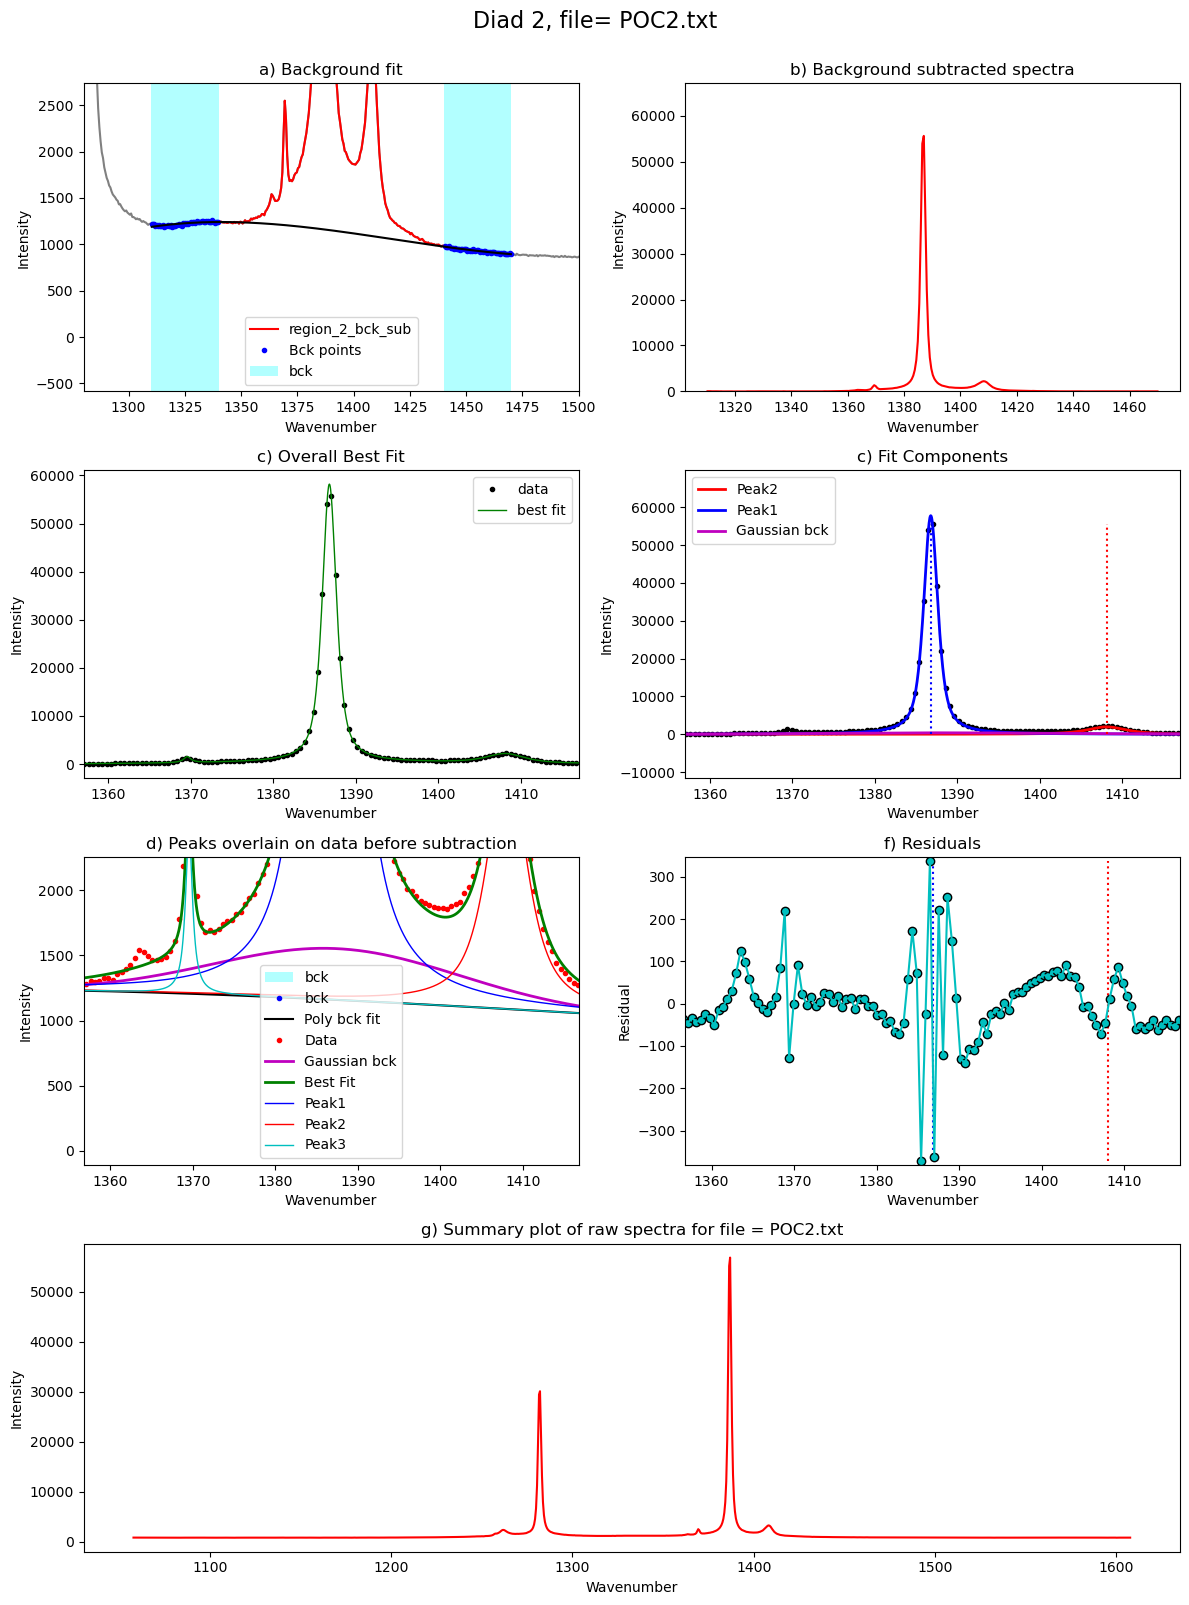

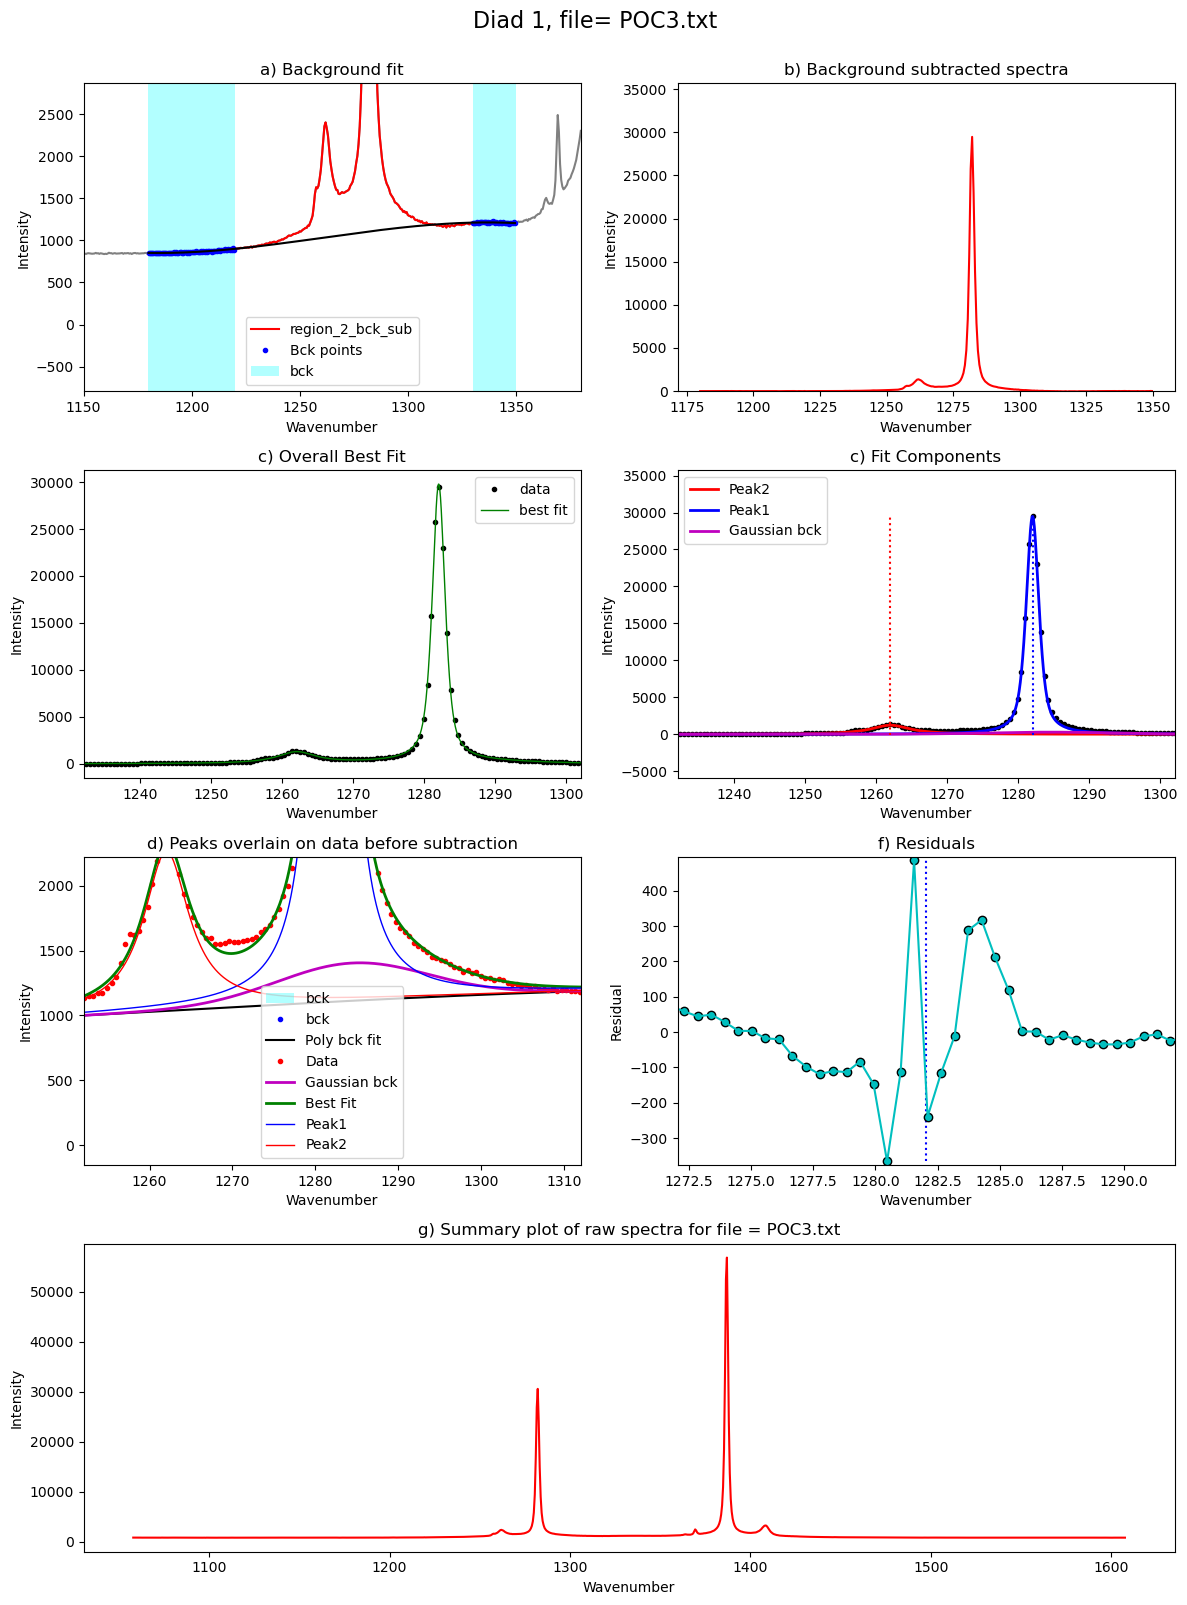

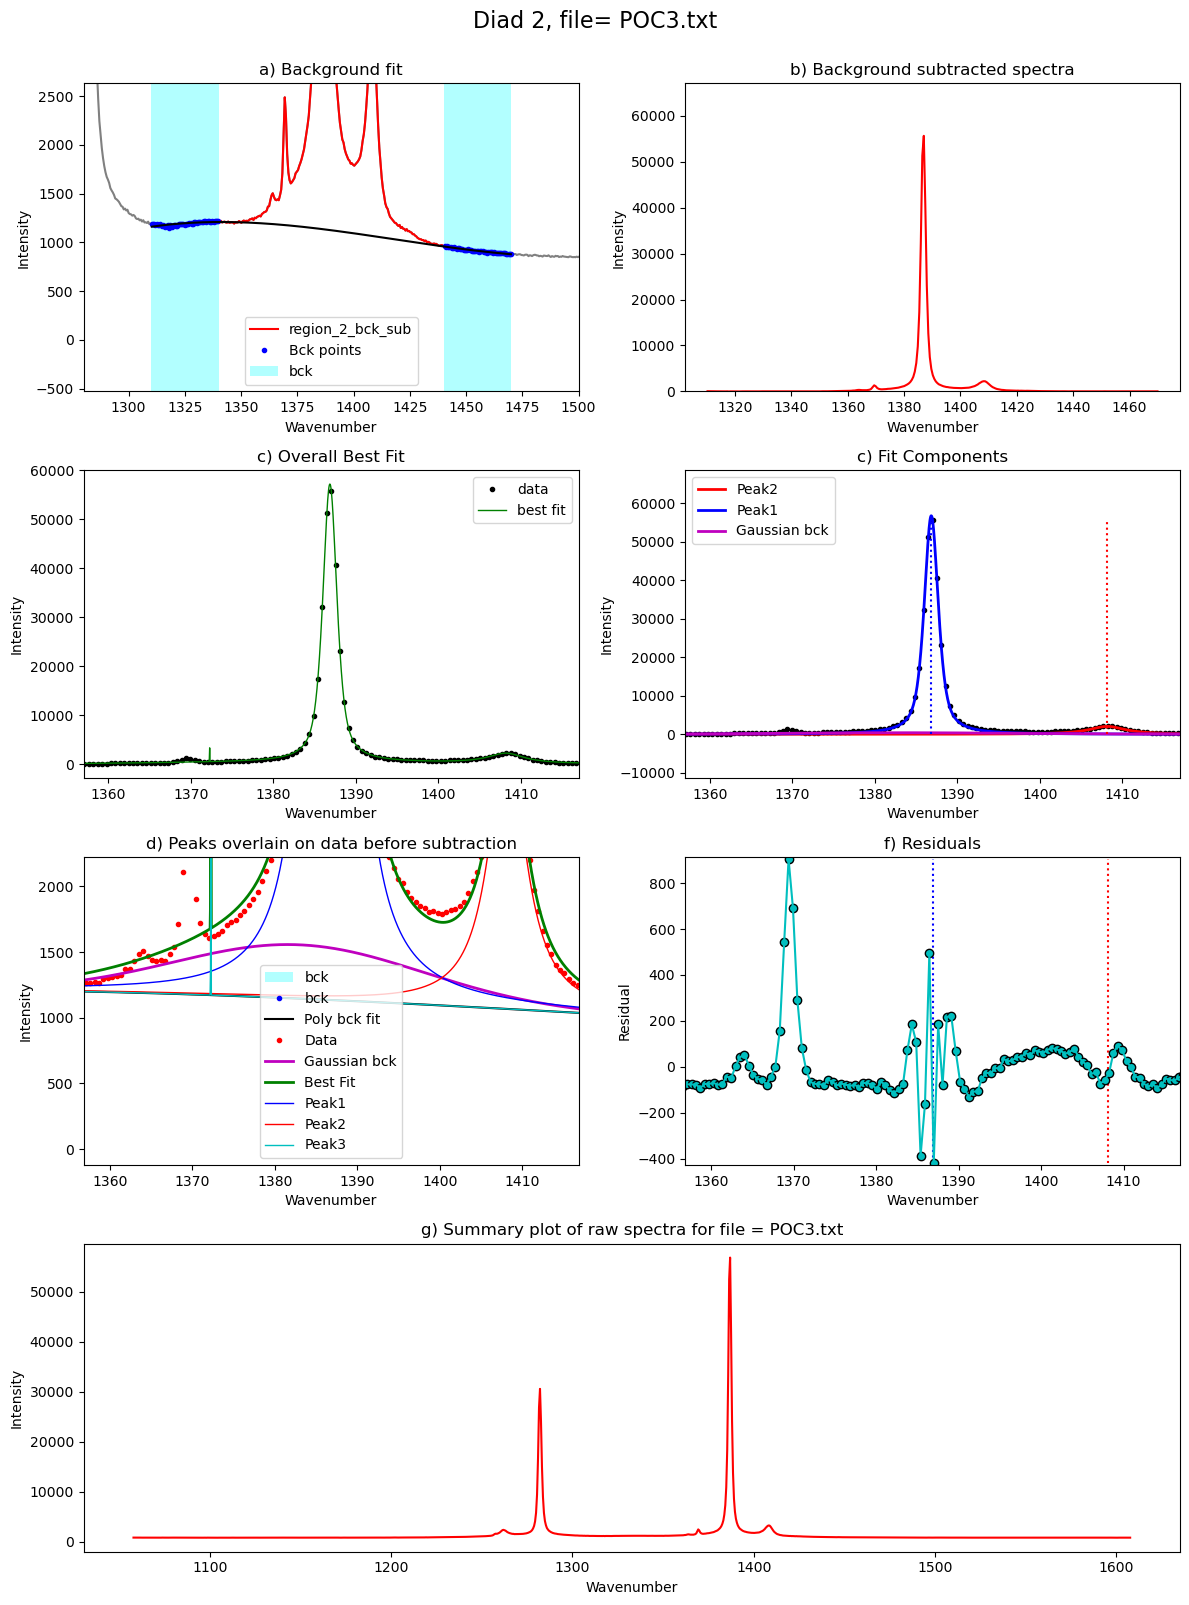

In [22]:
from tqdm import tqdm
plot_figure=True # If False, Means doesnt have to make figures, lot faster. 
close_figure=False # Means shows figures in the notebook itself
to_clipboard=False # Copies to clipboard
Diad_Files_Weak_i=Diad_Files_Weak
df_Weak = pd.DataFrame([])
for i in tqdm(range(0, len(Diad_Files_Weak))): #
    
    filename=Diad_Files_Weak[i]

    if fit_sec_peak is True:
    
        generic_fit=pf.fit_generic_peak(config=generic_Config, path=spectra_path, 
filename=filename, filetype=filetype)


    diad1_peaks, diad2_peaks=pf.identify_diad_peaks(config=diad_id_config,
            path=spectra_path, filename=filename,
filetype=filetype, n_peaks_diad1=n_peaks_diad1, 
    n_peaks_diad2=n_peaks_diad2, plot_figure=False)

    Diad1_fit=pf.fit_diad_1_w_bck(config1=diad1_fit_config,
    config2=diad_id_config, peak_pos_voigt=diad1_peaks,
path=spectra_path, filename=filename, filetype=filetype, close_figure=close_figure)

    Diad2_fit=pf.fit_diad_2_w_bck(config1=diad2_fit_config,
        config2=diad_id_config, peak_pos_voigt=diad2_peaks,
    path=spectra_path, filename=filename, filetype=filetype, close_figure=close_figure)
    
    
    if fit_sec_peak is True:
        data=pf.combine_diad_outputs(filename=filename, prefix=False, 
    Diad1_fit=Diad1_fit, path=spectra_path,
     to_clipboard=to_clipboard,                    
    Diad2_fit=Diad2_fit, Carb_fit=generic_fit)
    
    else:
        data=pf.combine_diad_outputs(filename=filename, prefix=False, 
    Diad1_fit=Diad1_fit, path=spectra_path,
     to_clipboard=to_clipboard,                    
    Diad2_fit=Diad2_fit)        
    
 

    df_Weak = pd.concat([df_Weak, data], axis=0)


## Here are some figures to inspect the relationship between residuals and areas etc. 

In [67]:
# These ones triggered at least one warning, so need to be refit
refit_d1=(df_Weak['Diad1_refit']==True)
refit_d2=(df_Weak['Diad2_refit']==True)
refit=refit_d1|refit_d2

In [68]:
sum(refit_d2)

3

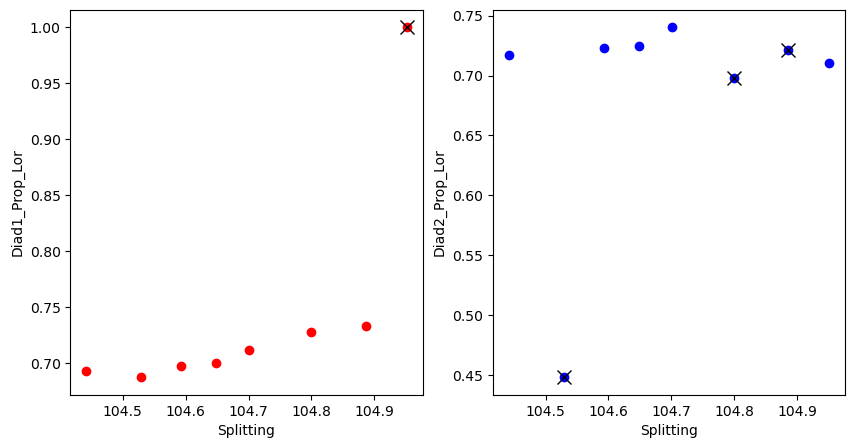

In [69]:

x='Splitting'
y1='Diad1_Prop_Lor'
y2='Diad2_Prop_Lor'
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
ax1.plot(df_Weak[x], df_Weak[y1], 'or')
ax2.plot(df_Weak[x], df_Weak[y2], 'ob')
ax1.plot(df_Weak[x].loc[refit_d1], df_Weak[y1].loc[refit_d1], 'xk', ms=10)
ax2.plot(df_Weak[x].loc[refit_d2], df_Weak[y2].loc[refit_d2], 'xk', ms=10)
ax1.set_xlabel(x)
ax2.set_xlabel(x)
ax1.set_ylabel(y1)
ax2.set_ylabel(y2)
df_not_too_Weak=df_Weak #.loc[(df_Weak['Diad1_Voigt_Area']>25) & (df_Weak['Diad2_Voigt_Area']>30)]

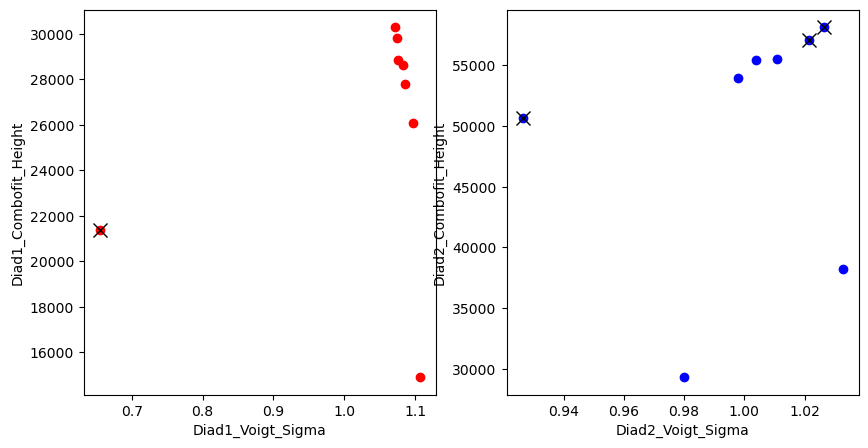

In [70]:
x1='Diad1_Voigt_Sigma'
x2='Diad2_Voigt_Sigma'
y1='Diad1_Combofit_Height'
y2='Diad2_Combofit_Height'
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
ax1.plot(df_Weak[x1], df_Weak[y1], 'or')
ax2.plot(df_Weak[x2], df_Weak[y2], 'ob')
ax1.plot(df_Weak[x1].loc[refit_d1], df_Weak[y1].loc[refit_d1], 'xk', ms=10)
ax2.plot(df_Weak[x2].loc[refit_d2], df_Weak[y2].loc[refit_d2], 'xk', ms=10)

ax1.set_xlabel(x1)
ax1.set_ylabel(y1)
ax2.set_xlabel(x2)
ax2.set_ylabel(y2)
df_not_too_Weak=df_Weak #.loc[(df_Weak['Diad1_Voigt_Area']>25) & (df_Weak['Diad2_Voigt_Area']>30)]

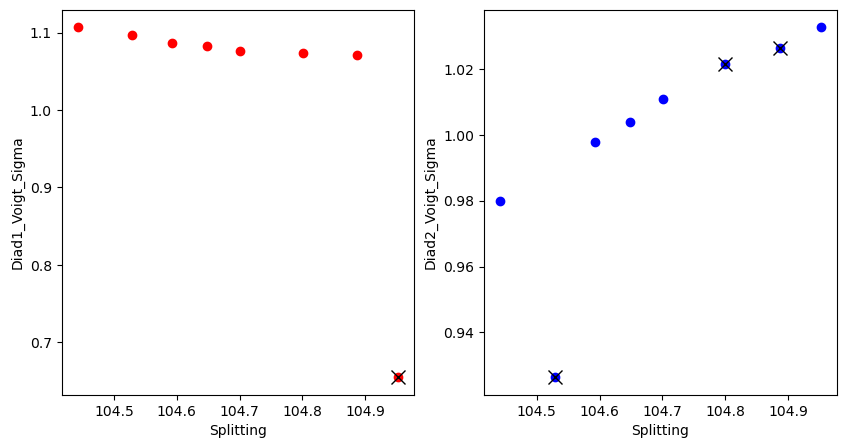

In [72]:
x='Splitting'
y1='Diad1_Voigt_Sigma'
y2='Diad2_Voigt_Sigma'
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
ax1.plot(df_Weak[x], df_Weak[y1], 'or')
ax2.plot(df_Weak[x], df_Weak[y2], 'ob')
ax1.plot(df_Weak[x].loc[refit_d1], df_Weak[y1].loc[refit_d1], 'xk', ms=10)
ax2.plot(df_Weak[x].loc[refit_d2], df_Weak[y2].loc[refit_d2], 'xk', ms=10)
ax1.set_xlabel(x)
ax2.set_xlabel(x)
ax1.set_ylabel(y1)
ax2.set_ylabel(y2)
df_not_too_Weak=df_Weak #.loc[(df_Weak['Diad1_Voigt_Area']>25) & (df_Weak['Diad2_Voigt_Area']>30)]

In [73]:
df_anom=df_Weak.loc[refit]
df_anom['filename']

0    POC1
0    POC7
0    POC2
0    POC3
Name: filename, dtype: object

g:\my drive\berkeley_new\diadfit_outer\src\DiadFit\diads.py:712: UserWarning: Diad fit right at the upper limit of the allowed fit parameter, change diad_amplitude in the diad1 config file
  w.warn('Diad fit right at the upper limit of the allowed fit parameter, change diad_amplitude in the diad1 config file')
g:\my drive\berkeley_new\diadfit_outer\src\DiadFit\diads.py:718: UserWarning: Diad fit right at the upper limit of the allowed fit parameter, change diad_sigma in the  diad1 config file
  w.warn('Diad fit right at the upper limit of the allowed fit parameter, change diad_sigma in the  diad1 config file')
g:\my drive\berkeley_new\diadfit_outer\src\DiadFit\diads.py:1138: UserWarning: Diad fit right at the upper limit of the allowed fit parameter, change diad_amplitude in the diad 2 config file
  w.warn('Diad fit right at the upper limit of the allowed fit parameter, change diad_amplitude in the diad 2 config file')
g:\my drive\berkeley_new\diadfit_outer\src\DiadFit\diads.py:1144: U

NameError: name 'generic_fit' is not defined

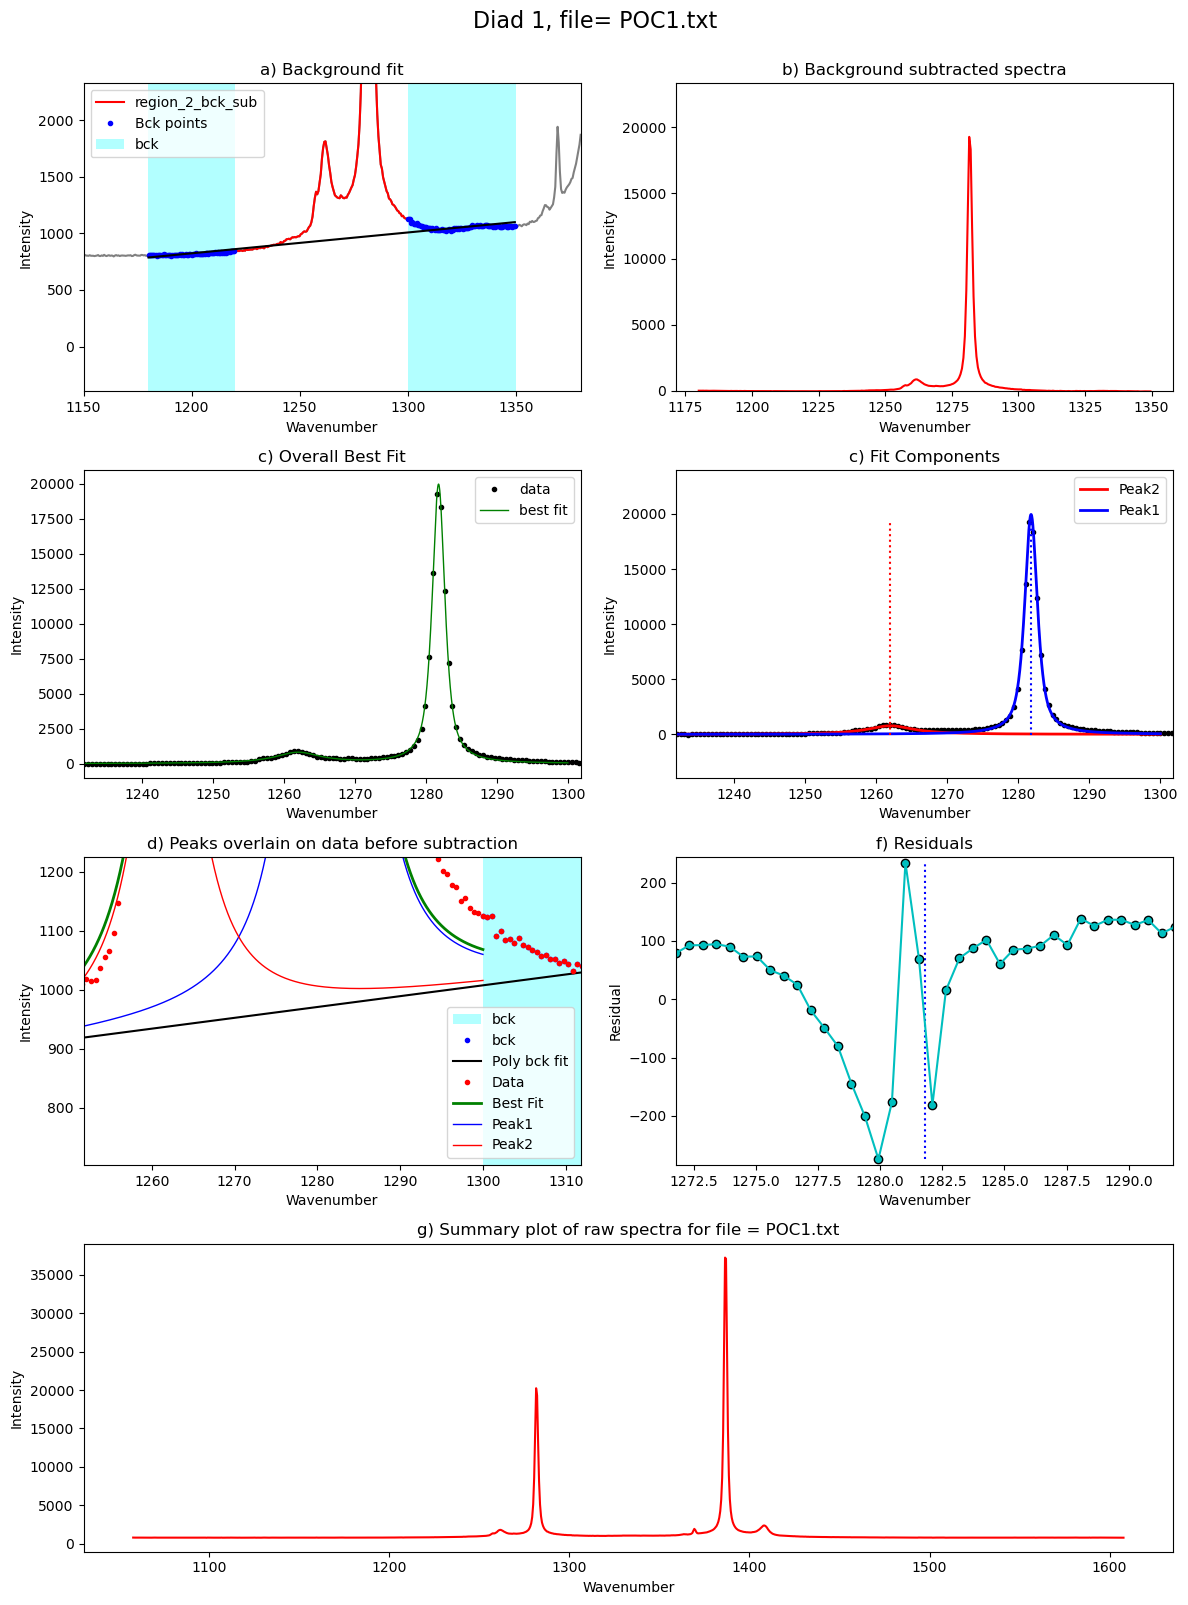

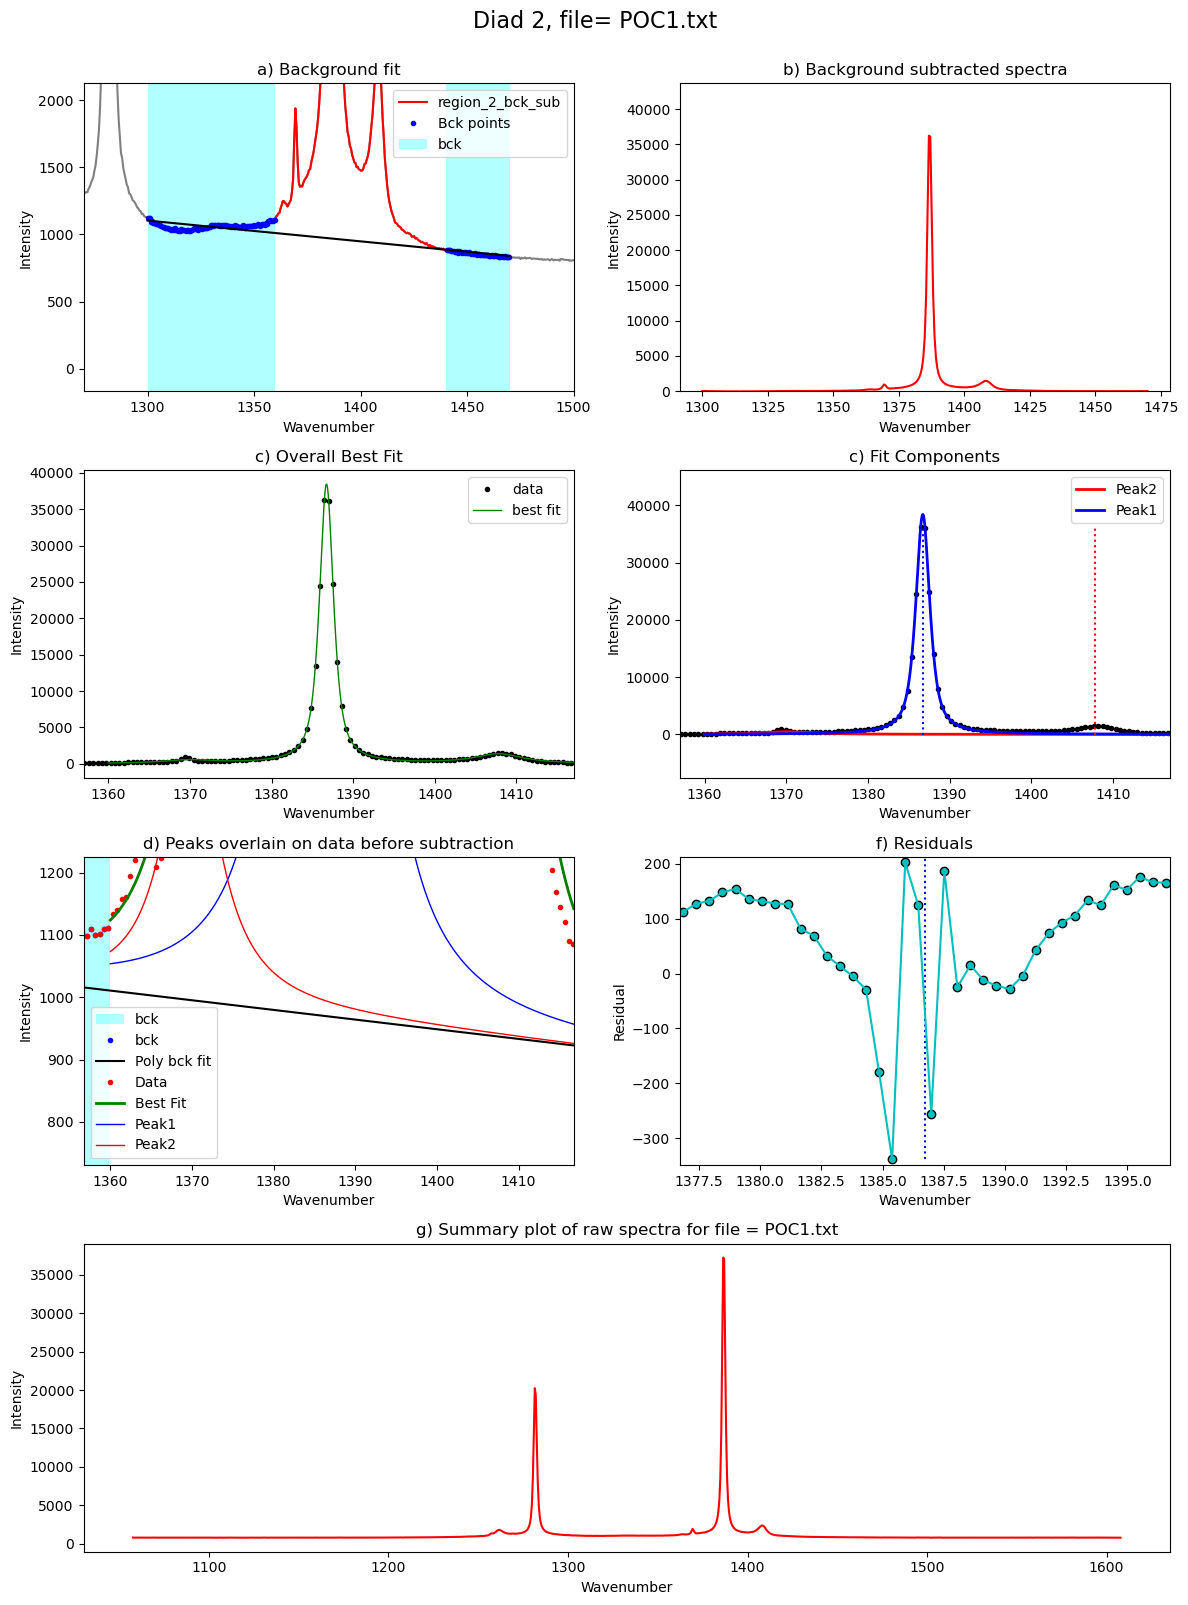

In [74]:
if sum(refit_d2)>0:
    filename_refit=df_anom['filename'].iloc[0] + file_ext



    diad1_fit_config_refit=pf.diad1_fit_config(model_name=model_name,
    diad_sigma=0.3, sigma_allowance=1.1,
    x_range_residual=10, 
    x_range_baseline=30, HB_amplitude=5, diad_amplitude=100)


    diad2_fit_config_refit=pf.diad2_fit_config(model_name=model_name,
    diad_sigma=0.2, sigma_allowance=1.1,  
                                x_range_residual=10, 
                                diad_amplitude=400, 
                            x_range_baseline=30)
    diad2_fit_config


    Diad1_refit=pf.fit_diad_1_w_bck(config1=diad1_fit_config_refit,
        config2=diad_id_config, peak_pos_voigt=diad1_peaks,
    path=spectra_path, filename=filename_refit, filetype=filetype, close_figure=False)



    Diad2_refit=pf.fit_diad_2_w_bck(config1=diad2_fit_config_refit,
        config2=diad_id_config, peak_pos_voigt=diad2_peaks,                              
    path=spectra_path, filename=filename_refit, filetype=filetype, close_figure=False)



    data_refit=pf.combine_diad_outputs(filename=filename, prefix=False, 
    Diad1_fit=Diad1_fit, path=spectra_path,
     to_clipboard=to_clipboard,                    
    Diad2_fit=Diad2_fit, Carb_fit=generic_fit)

    data_refit

In [128]:
if sum(refit_d2)>0:
    from tqdm import tqdm
    plot_figure=True # If False, Means doesnt have to make figures, lot faster. 
    close_figure=False # Means shows figures in the notebook itself
    to_clipboard=False # Copies to clipboard

    df_Weak_refit = pd.DataFrame([])
    for i in tqdm(range(0, len(df_anom))):

        filename=df_anom['filename'].iloc[i] + file_ext

        generic_fit=pf.fit_generic_peak(config=generic_Config, path=spectra_path, 
    filename=filename, filetype=filetype)


        diad1_peaks, diad2_peaks=pf.identify_diad_peaks(config=diad_id_config,
                path=spectra_path, filename=filename,
    filetype=filetype, n_peaks_diad1=n_peaks_diad1, 
        n_peaks_diad2=n_peaks_diad2, plot_figure=False)

        Diad1_fit=pf.fit_diad_1_w_bck(config1=diad1_fit_config_refit,
        config2=diad_id_config, peak_pos_voigt=diad1_peaks,
    path=spectra_path, filename=filename, filetype=filetype, close_figure=close_figure)

        Diad2_fit=pf.fit_diad_2_w_bck(config1=diad2_fit_config_refit,
            config2=diad_id_config, peak_pos_voigt=diad2_peaks,
        path=spectra_path, filename=filename, filetype=filetype, close_figure=close_figure)



        data_refit=pf.combine_diad_outputs(filename=filename, prefix=False, 
    Diad1_fit=Diad1_fit, path=spectra_path,
     to_clipboard=to_clipboard,                    
    Diad2_fit=Diad2_fit, Carb_fit=generic_fit)
    
 

        df_Weak_refit = pd.concat([df_Weak_refit, data_refit], axis=0)

## Insert this into the dataframe

In [129]:
## First remove the bad rows from the old dataframe
if sum(refit_d2)>0:
    Keep=df_Weak.loc[~refit]
    combo=pd.concat([df_Weak, df_Weak_refit], axis=0)
else:
    combo=df_Weak

In [75]:
combo=df_Weak

In [76]:
combo.to_excel('Med_Diads.xlsx')

In [77]:
combo.to_clipboard(excel=True)